# Bayesian Optimization using MC dropout

References

1. https://distill.pub/2020/bayesian-optimization/
2. https://proceedings.mlr.press/v48/gal16.pdf
3. https://github.com/nipunbatra/pml-teaching/blob/master/notebooks/monte-carlo-dropout.ipynb
4. https://github.com/nipunbatra/pml-teaching/blob/master/notebooks/bayesopt.ipynb



In [440]:
import torch
import torch.distributions as dist
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np 
from scipy.stats import norm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from mpl_toolkits.mplot3d import Axes3D

# Black box function

In [437]:
def f(x):
    means = [-2, 0, 3, 2]  # Mean values for the Gaussian components
    variances = [1, 1, 1, 1]  # Variance values for the Gaussian components
    amplitudes = [2, 0.5, 4, 0.8]  # Amplitude values for the Gaussian components
    variances = torch.tensor(variances)
    pdfs = []
    for mean, variance, amplitude in zip(means, variances, amplitudes):
        pdf = amplitude * torch.exp(-0.5 * ((x - mean) / variance)**2) / torch.sqrt(2 * np.pi * variance**2)
        pdfs.append(pdf)
    mixture_pdf = sum(pdfs)
    return mixture_pdf
# Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(x.numpy(), mixture_pdf.numpy(), label='f(x)', color='blue')
# # for mean, variance, amplitude in zip(means, variances, amplitudes):
# #     plt.plot(x.numpy(), amplitude * torch.exp(-0.5 * ((x - mean) / variance)**2) / torch.sqrt(2 * np.pi * variance**2),
# #              label=f'Gaussian (Mean={mean}, Var={variance}, Amp={amplitude})', linestyle='--')
# plt.title('Mixture of four Gaussian Functions',fontsize=20)
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.legend()
# plt.show()

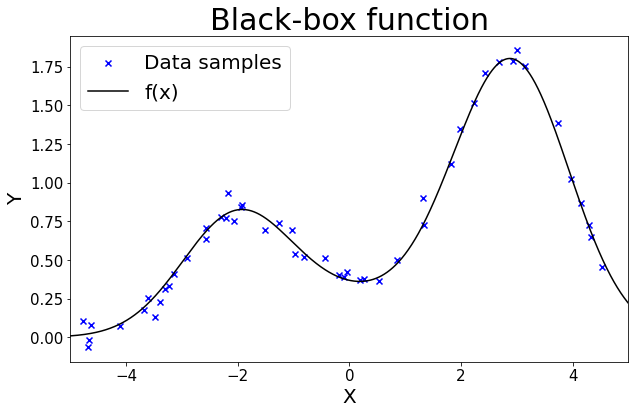

In [438]:
torch.manual_seed(0)
N_TOT = 50
X_dataset = torch.distributions.Uniform(-5, 5).sample((N_TOT, 1))
f_dataset = f(X_dataset)
y_dataset = f_dataset + torch.distributions.Normal(0, 0.05).sample((N_TOT, 1))
x_all = torch.linspace(-5, 5, 1000) 
def plot_dataset(ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    # Plot the dataset
    ax.scatter(X_dataset.numpy(), y_dataset.numpy(), c='b', marker='x', label='Data samples')
    ax.plot(x_all, f(x_all), label='f(x)',c = 'k')
    ax.legend(fontsize=20)
    ax.set_xlim(-5, 5)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('X',fontsize=20)
    plt.ylabel('Y',fontsize=20)
    plt.title('Black-box function',fontsize=30)
plot_dataset()

In [423]:
y_dataset.max()

tensor(1.8364)

1. Goal is to label those points which gives the maxima of the black-box function using Bayesian optimization

2. Surrogate model used is MLP with MC dropout

# Surrogate model - MLP

In [411]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2,hidden_dim3, output_dim, dropout_prob=0.5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        self.dropout1 = nn.Dropout(p=dropout_prob)
        self.dropout2 = nn.Dropout(p=dropout_prob)
        self.dropout3 = nn.Dropout(p=dropout_prob)

    def forward(self, x, training=True):
        x = F.relu(self.fc1(x))
        if training:
            x = self.dropout1(x)  # Apply dropout to first hidden layer if in training mode
        x = F.relu(self.fc2(x))
        if training:
            x = self.dropout2(x)  # Apply dropout to second hidden layer if in training mode
        x = F.relu(self.fc3(x))
        if training:
            x = self.dropout3(x)  # Apply dropout to third hidden layer if in training mode
        x = self.fc4(x)
        return x

# Acquisition function

In [412]:
# Acquisition function
def probability_of_improvement(mean_predictions, std_predictions, y_max, epsilon=1e-3):
    z = (mean_predictions - y_max - epsilon) / (std_predictions)
    pi = norm.cdf(z)
    return pi

def upper_confidence_bound(mean_predictions, std_predictions, beta=1.0):
    ucb = mean_predictions + beta * std_predictions
    return ucb


# Plotting

In [413]:
def update(model, x_new, y_new, optimizer, criterion, num_epochs=1000):
    x_new = torch.tensor(x_new, dtype=torch.float32).unsqueeze(0)
    y_new = torch.tensor(y_new, dtype=torch.float32)

        # Training loop for updating the model parameters
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(x_new) 
        loss = criterion(outputs, y_new)
        loss.backward()
        optimizer.step()
    return model
            
# Compute posterior predictive 
def posterior_predictive(model, x, p = 0.3):
    preds = []
    for i in range(100):
        with torch.no_grad():
            y_hat_dropout = model(x).ravel()
        preds.append(y_hat_dropout.numpy())

    # Calculate mean and standard deviation across MC dropout samples
    mean_predictions = np.mean(preds, axis=0)
    std_predictions = np.std(preds, axis=0)
    return mean_predictions, std_predictions

# Plotting posterior predictive 
def plot_posterior_predictive(X_data, y_data, x_obs, y_obs, X_sel, y_sel, model, num_samples=1000, ax=None):
        
    # Calculate mean and standard deviation
    if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))
    x_plot = torch.linspace(-5, 5, 1000)[:, None]
    mean_predictions, std_predictions = posterior_predictive(model, x_plot, p=0.5)
    ax.scatter(X_data, y_data, label='Total data', color='green', marker='x',alpha=0.4)
    if x_obs is None or y_obs is None or X_sel is None or y_sel is None:
        pass
    else:
        ax.scatter(x_obs, y_obs, label='observed data', color='purple', marker='*', alpha = 0.8, s=200)
        ax.scatter(X_sel, y_sel, label='selected data', color='black', marker='*', s=200)
             # Plot the current maximum
        x_max = X_sel[y_sel.argmax()]
        y_max = y_sel.max()
        ax.axhline(y_max, c='k', linestyle='--', label='Current Max')
        ax.axvline(x_max, c='k', linestyle='--')
    
    ax.plot(x_all, f(x_all), label='f(x)',c = 'k')
    ax.plot(x_plot[:,0], mean_predictions, label='Posterior Mean', color='red', alpha =0.4)

    ax.fill_between(x_plot[:,0], mean_predictions - 2*std_predictions, mean_predictions + 2*std_predictions, color='orange', alpha=0.2, label='Uncertainity(2std)')
    plt.xlabel('X')
    plt.ylabel('Y')
    if x_obs is None or y_obs is None or X_sel is None or y_sel is None:
        plt.title('Prior Predictive',fontsize=20)
    else:
        plt.title('Posterior Predictive',fontsize=20)
    plt.xlim(-5,5)
    plt.xlabel('X',fontsize=30)
    plt.ylabel('Y',fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=15, borderaxespad=0.)

    plt.show()
    

# MC dropout implementation

In [416]:
def MC_dropout_loop(model, num_iterations,X_new, y_new, X_dataset, y_dataset, optimizer, num_epochs=1000):
    X_data_full = X_dataset.clone()
    y_data_full = y_dataset.clone()
    X_train = X_new.clone()
    y_train = y_new.clone()
    X_obs = X_train.clone()
    y_obs = y_train.clone()
   
    for i in range(num_iterations):
        # Update model with current data
        model = update(model, X_obs, y_obs, optimizer, criterion, num_epochs=num_epochs)
        
        # Perform MC dropout prediction
        mean_predictions, std_predictions = posterior_predictive(model, X_dataset, p=0.5)
        next_x = X_dataset[i].item()
        next_y = y_dataset[i].item()
        
            # Add new point to training data
        X_train = torch.cat((X_train, torch.tensor([[next_x]])))
        y_train = torch.cat((y_train, torch.tensor([[next_y]])))
        
        X_obs = torch.cat((X_obs, torch.tensor([[next_x]])))
        y_obs = torch.cat((y_obs, torch.tensor([[next_y]])))    

    plot_MC_dropout(X_data_full, y_data_full, X_obs.detach().numpy(), y_obs.detach().numpy(), X_train.detach().numpy(), y_train.detach().numpy(), model)

    return X_train, y_train

def plot_MC_dropout(X_data, y_data, x_obs, y_obs, X_sel, y_sel, model, num_samples=1000, ax=None):
        
    # Calculate mean and standard deviation
    if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))
    x_plot = torch.linspace(-5, 5, 1000)[:, None]
    mean_predictions, std_predictions = posterior_predictive(model, x_plot, p=0.5)
    ax.scatter(X_data, y_data, label='Total data', color='green', marker='x',alpha=0.4)
    ax.plot(x_all, f(x_all), label='f(x)',c = 'k')
    ax.plot(x_plot[:,0], mean_predictions, label='Posterior Mean', color='red', alpha =0.4)

    ax.fill_between(x_plot[:,0], mean_predictions - 2*std_predictions, mean_predictions + 2*std_predictions, color='orange', alpha=0.2, label='Uncertainity(2std)')
    plt.xlabel('X')
    plt.ylabel('Y')
    if x_obs is None or y_obs is None or X_sel is None or y_sel is None:
        plt.title('Prior Predictive',fontsize=20)
    else:
        plt.title('MC_dropout_fit',fontsize=20)
    plt.xlim(-5,5)
    
    plt.xlabel('X',fontsize=30)
    plt.ylabel('Y',fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=15, borderaxespad=0.)

    plt.show()

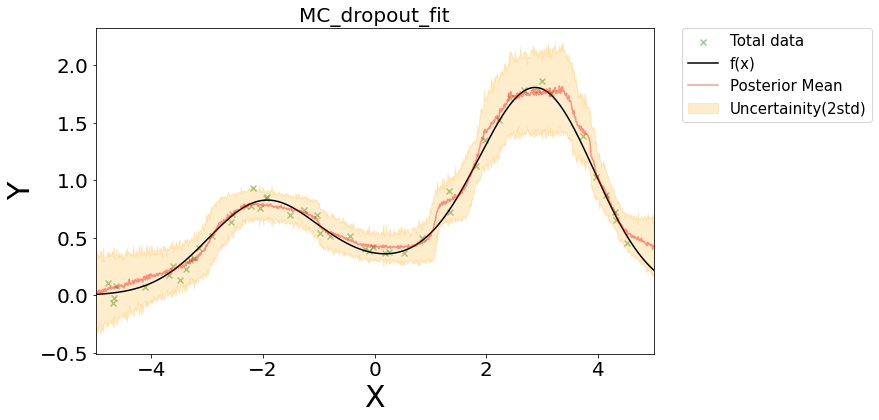

In [417]:
input_dim = 1
hidden_l1_dim = 100
hidden_l2_dim = 100
hidden_l3_dim = 100
output_dim = 1

model = MLP(input_dim, hidden_l1_dim, hidden_l2_dim,hidden_l3_dim,output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

num_iterations = 50
for ind in range(num_iterations):
    # Select one data point
    X_new = X_dataset[ind].unsqueeze(0)
    y_new = y_dataset[ind].unsqueeze(0)

X_train, y_train = MC_dropout_loop(model, num_iterations, X_new, y_new, X_dataset, y_dataset, optimizer)

# Bayesian Optimization loop 

In [431]:
def bayesian_optimization_loop(model, num_iterations, acquisition_function,X_new, y_new, X_dataset, y_dataset, optimizer, num_epochs=1000):
    X_data_full = X_dataset.clone()
    y_data_full = y_dataset.clone()
    X_train = X_new.clone()
    y_train = y_new.clone()
    X_obs = X_train.clone()
    y_obs = y_train.clone()
    max_values =[]
    for i in range(num_iterations):
        # Update model with current data
        model = update(model, X_obs, y_obs, optimizer, criterion, num_epochs=num_epochs)
        
        # Perform MC dropout prediction
        mean_predictions, std_predictions = posterior_predictive(model, X_dataset, p=0.5)
        
        y_max = y_train.max()
        
        # Calculate acquisition function values
        acquisition_values = acquisition_function(mean_predictions, std_predictions, y_max.detach().numpy())
         # Select new point with highest acquisition value
        next_idx = np.argmax(acquisition_values)
#         print(next_idx)
        next_x = X_dataset[next_idx].item()
        next_y = y_dataset[next_idx].item()
        
        if next_y > y_max:
        # Add new point to training data
            X_train = torch.cat((X_train, torch.tensor([[next_x]])))
            y_train = torch.cat((y_train, torch.tensor([[next_y]])))
        
        X_obs = torch.cat((X_obs, torch.tensor([[next_x]])))
        y_obs = torch.cat((y_obs, torch.tensor([[next_y]])))
        #recording Y_max values
        max_values.append(float(y_max))
        # Remove selected point from dataset
        X_dataset = X_dataset[X_dataset!=X_dataset[next_idx]][:,None]
        y_dataset = y_dataset[y_dataset!=y_dataset[next_idx]][:,None]
        plot_posterior_predictive(X_data_full, y_data_full, X_obs.detach().numpy(), y_obs.detach().numpy(), X_train.detach().numpy(), y_train.detach().numpy(), model)

    return X_train, y_train, max_values

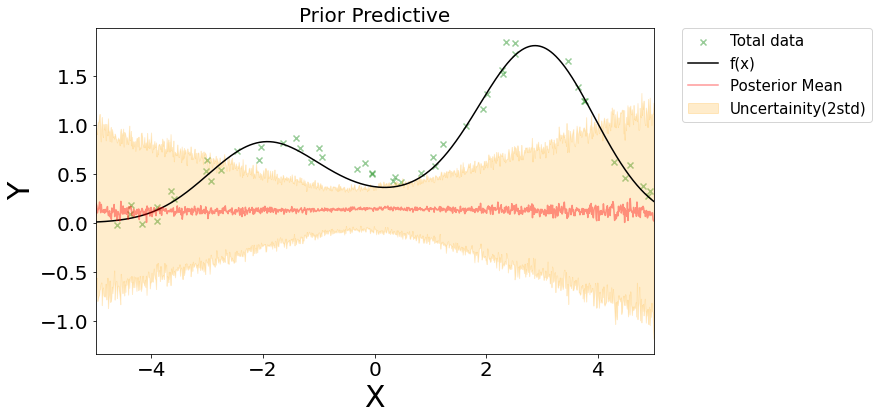

In [419]:
# Prior predictive plot
input_dim = 1
hidden_l1_dim = 100
hidden_l2_dim = 100
hidden_l3_dim = 100
output_dim = 1

model = MLP(input_dim, hidden_l1_dim, hidden_l2_dim,hidden_l3_dim,output_dim)
N_TOT = 50
X_dataset = torch.distributions.Uniform(-5, 5).sample((N_TOT, 1))
f_dataset = f(X_dataset)
y_dataset = f_dataset + torch.distributions.Normal(0, 0.1).sample((N_TOT, 1))
plot_posterior_predictive(X_dataset, y_dataset, None, None, None, None, model)

# Probability of improvement

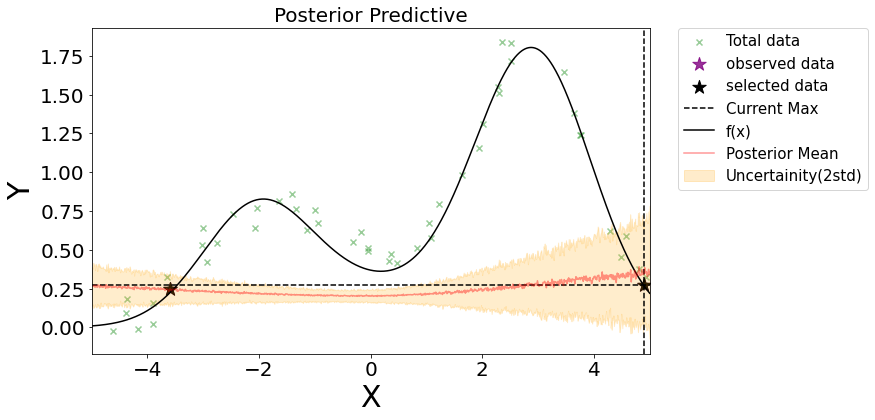

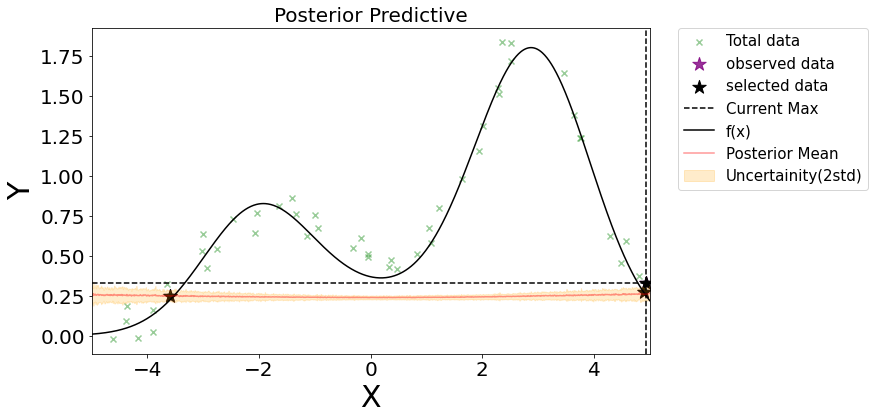

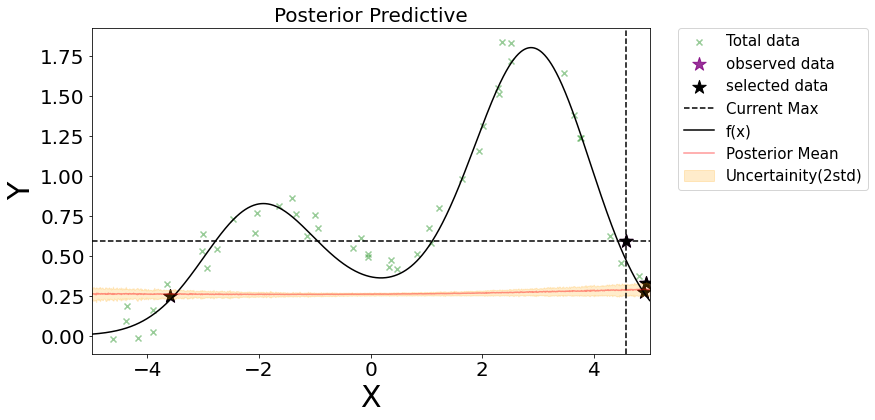

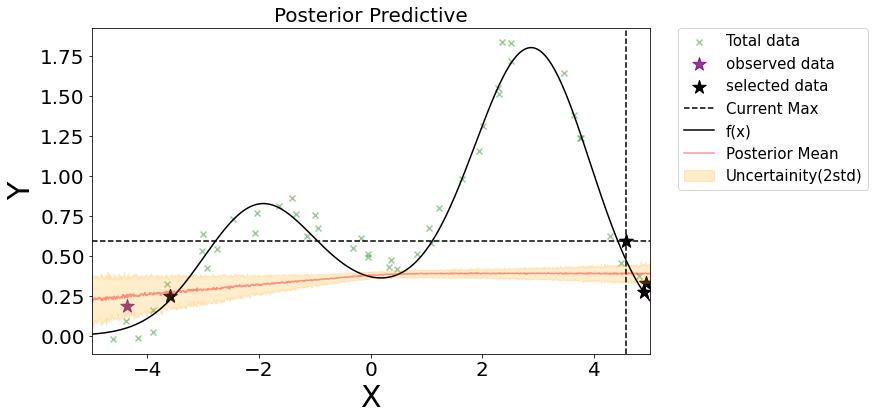

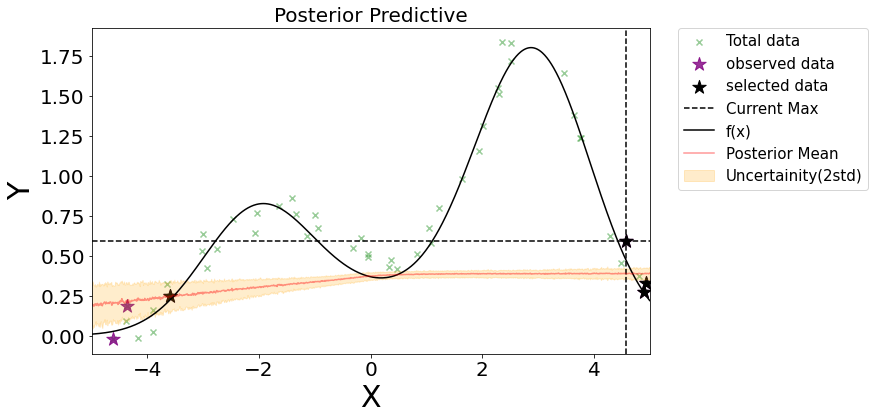

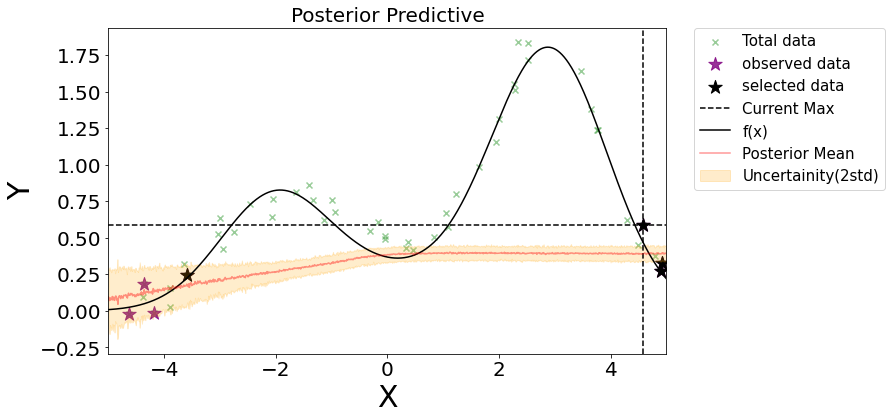

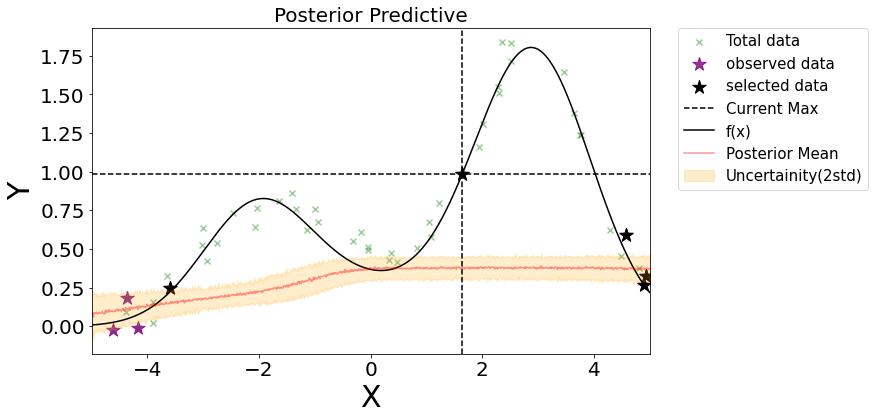

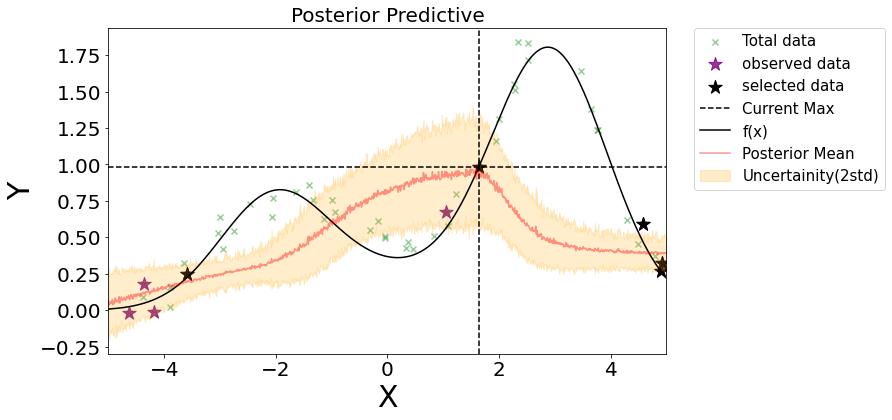

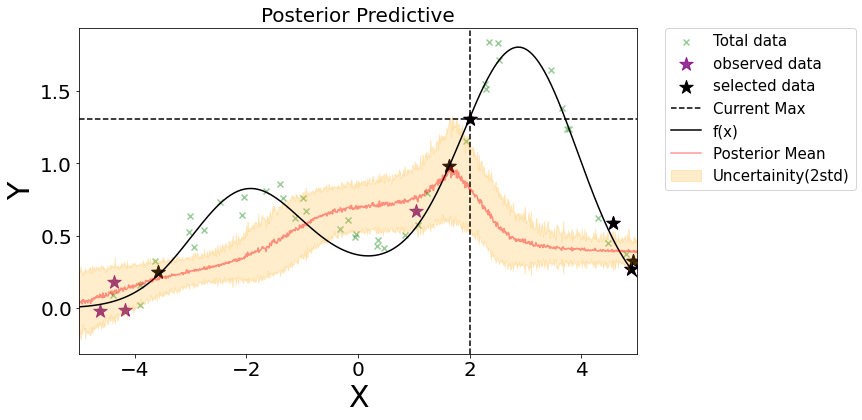

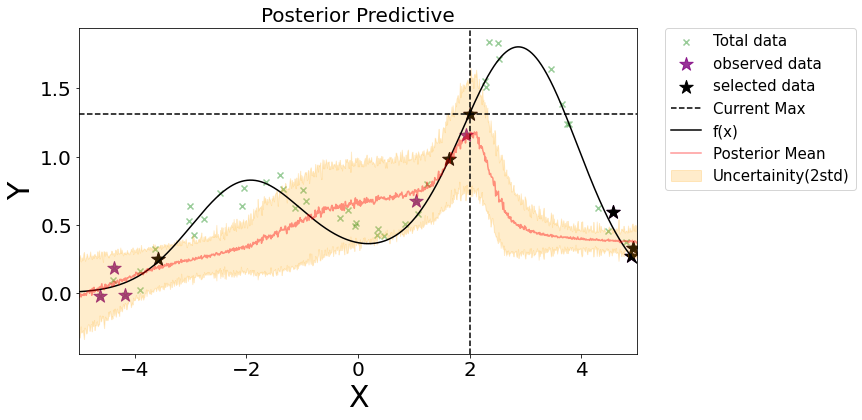

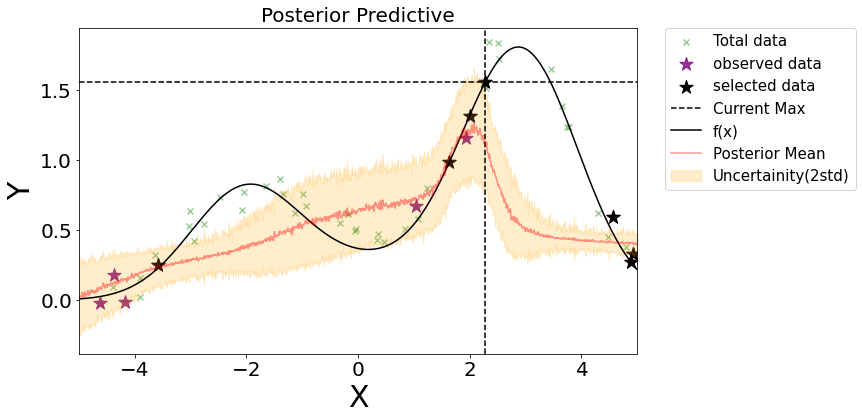

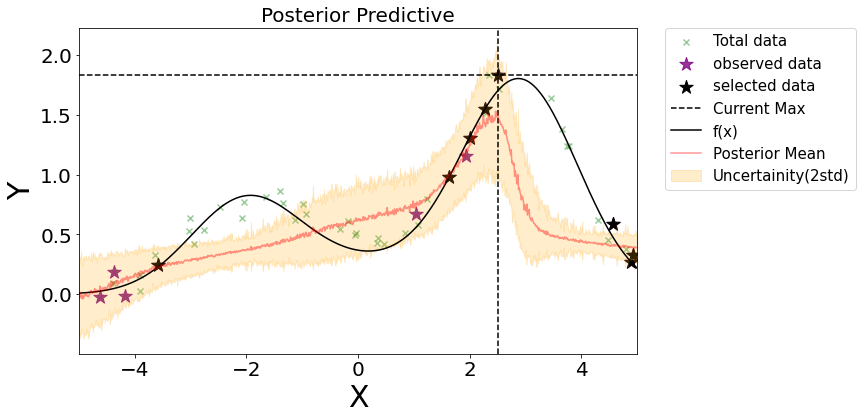

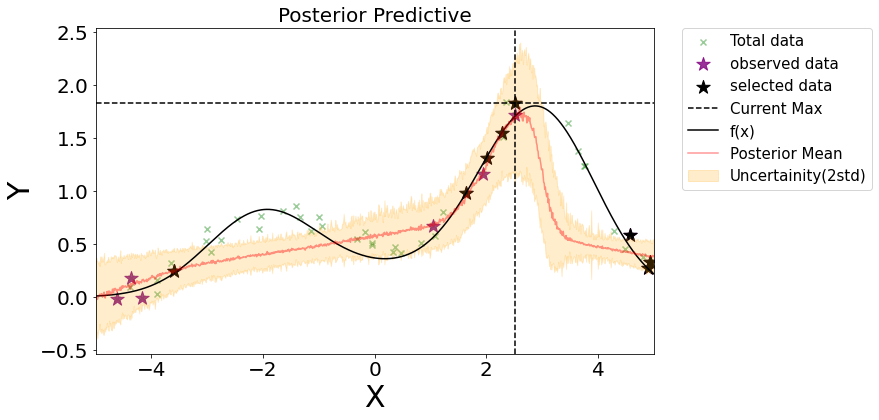

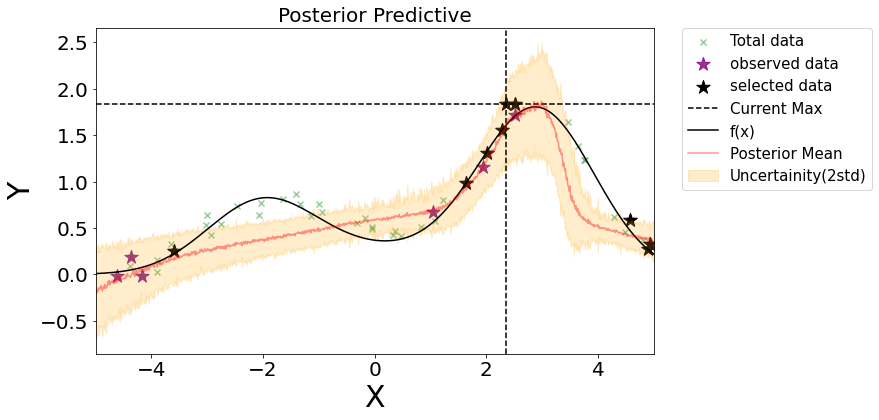

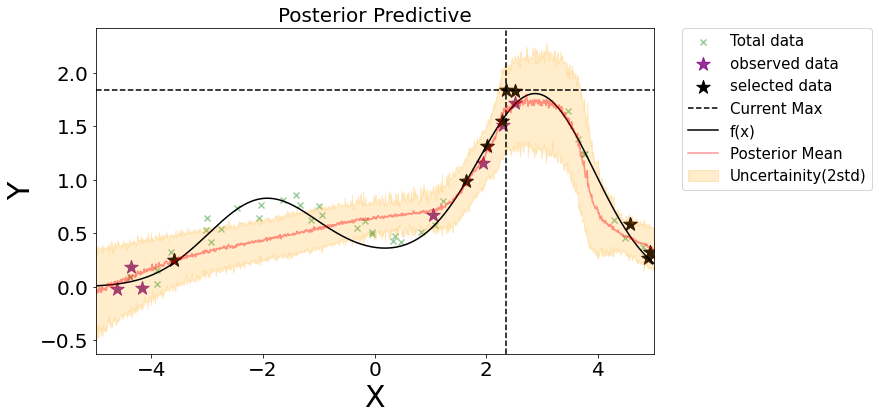

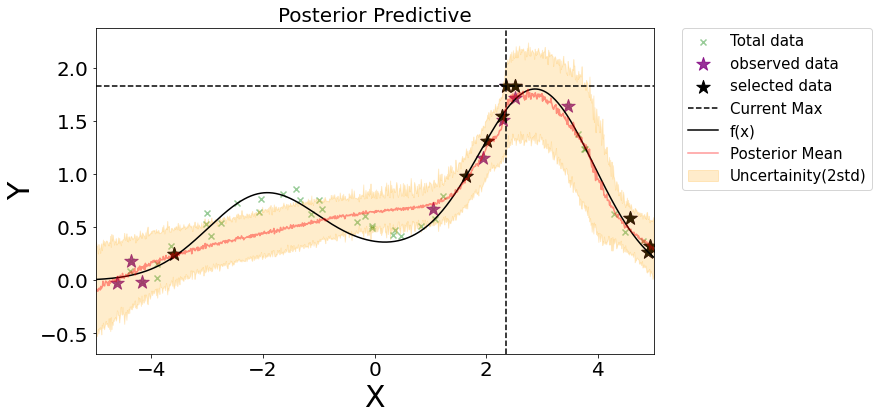

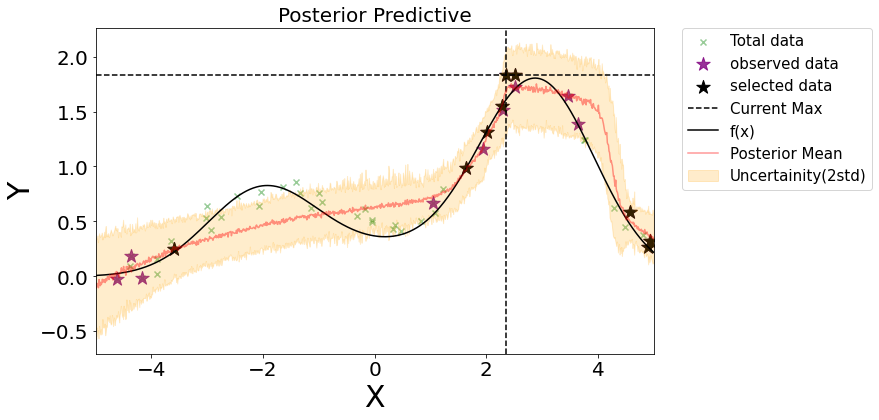

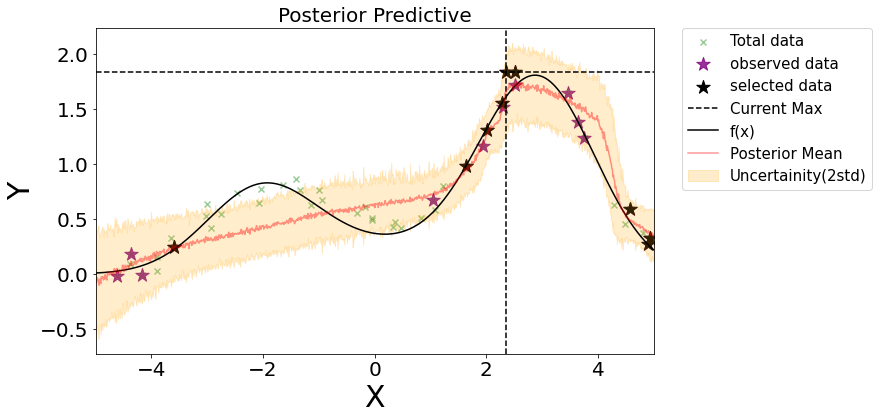

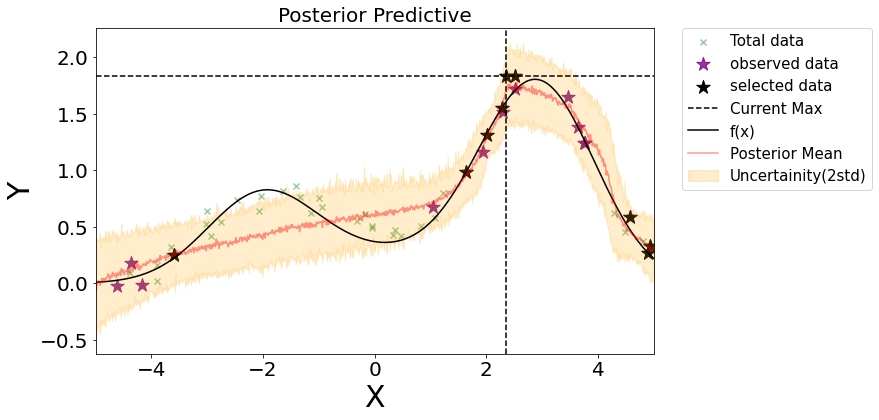

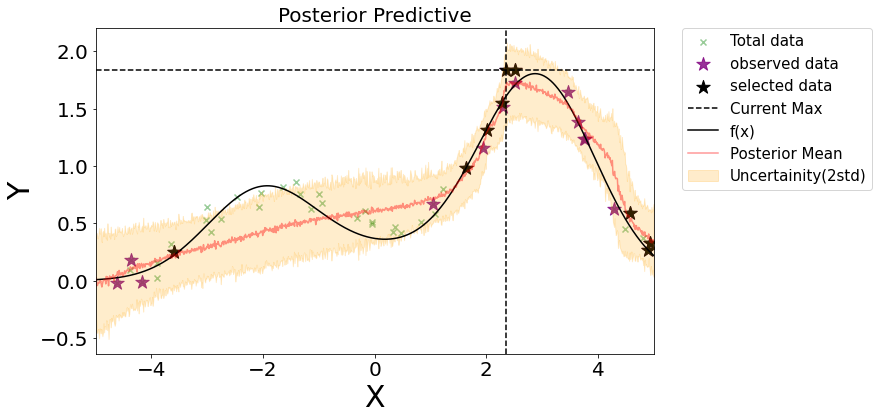

selected X:
tensor([[-3.5914],
        [ 4.9008],
        [ 4.9255],
        [ 4.5723],
        [ 1.6369],
        [ 2.0080],
        [ 2.2767],
        [ 2.5102],
        [ 2.3478]])
Final y:
tensor([[0.2473],
        [0.2703],
        [0.3264],
        [0.5898],
        [0.9832],
        [1.3106],
        [1.5516],
        [1.8317],
        [1.8364]])


In [434]:
input_dim = 1
hidden_l1_dim = 100
hidden_l2_dim = 100
hidden_l3_dim = 100
output_dim = 1
num_iterations = 20
model = MLP(input_dim, hidden_l1_dim, hidden_l2_dim,hidden_l3_dim,output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


ind = np.random.randint(50,size = 1)[0]
X_new = X_dataset[ind][:,None]
y_new = y_dataset[ind][:, None]

X_train, y_train, max_values_PI = bayesian_optimization_loop(model, num_iterations,probability_of_improvement,  X_new, y_new, X_dataset, y_dataset, optimizer)

print("selected X:")
print(X_train)
print("Final y:")
print(y_train)
# print("Max y_PI:")
# print(max_values_PI)

# upper_confidence_bound

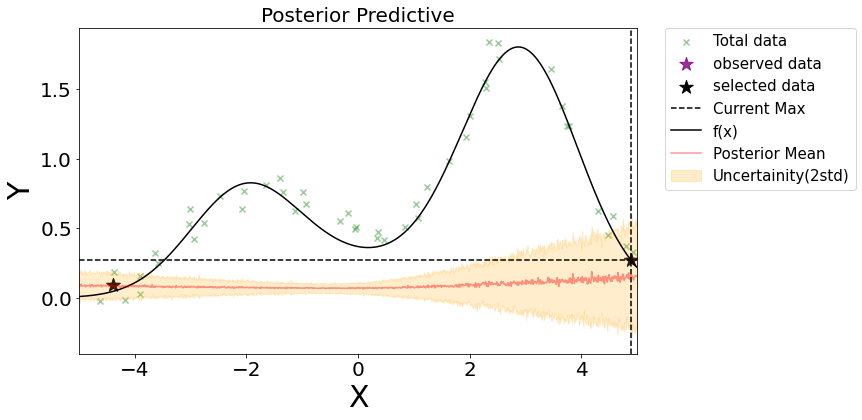

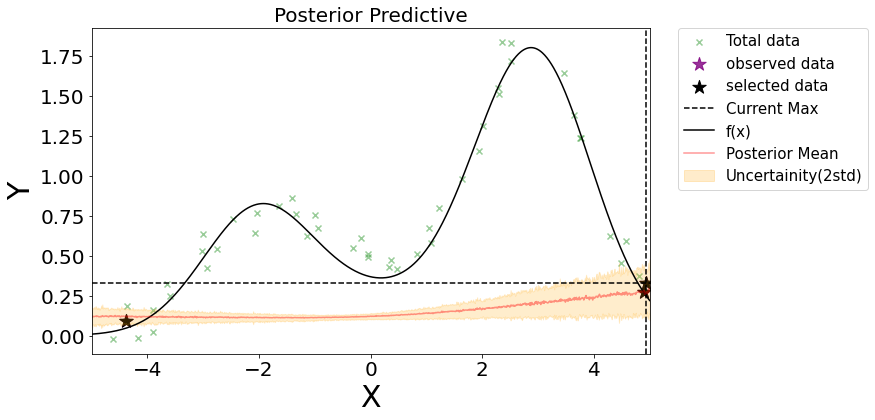

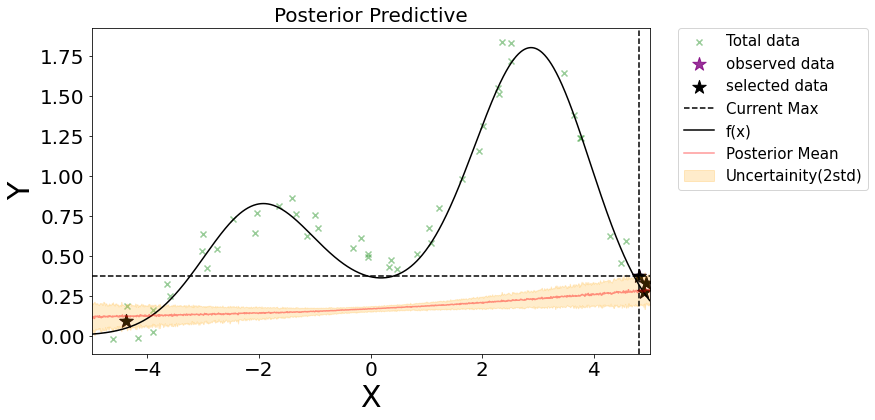

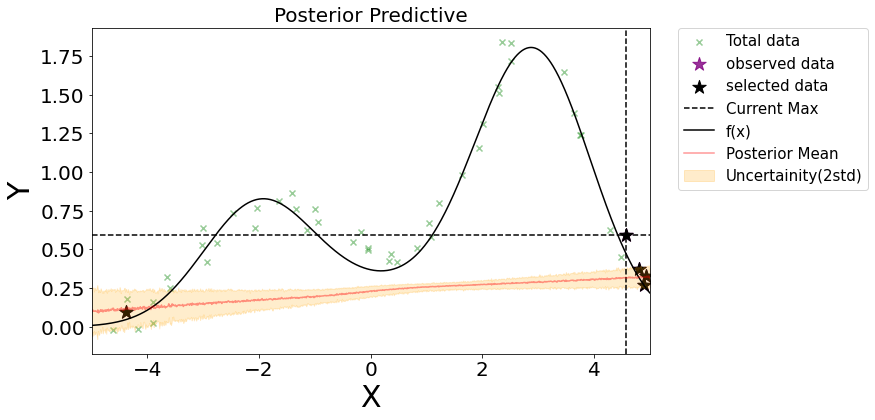

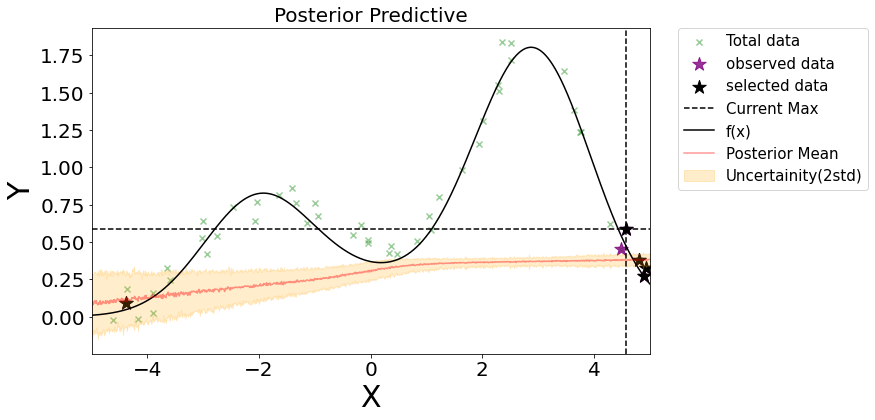

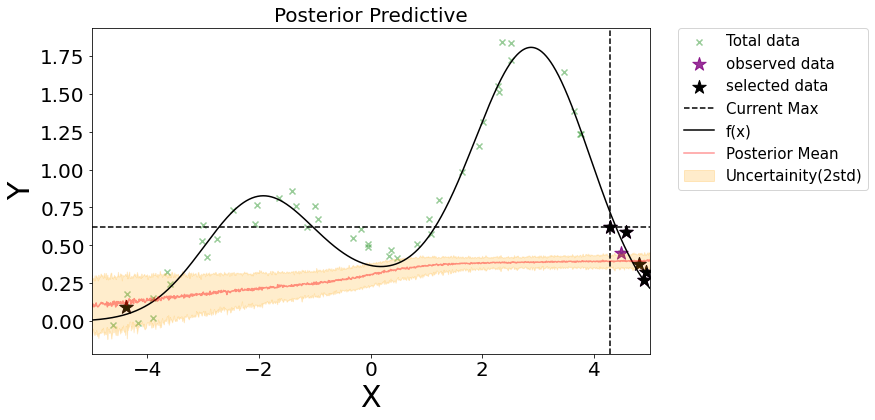

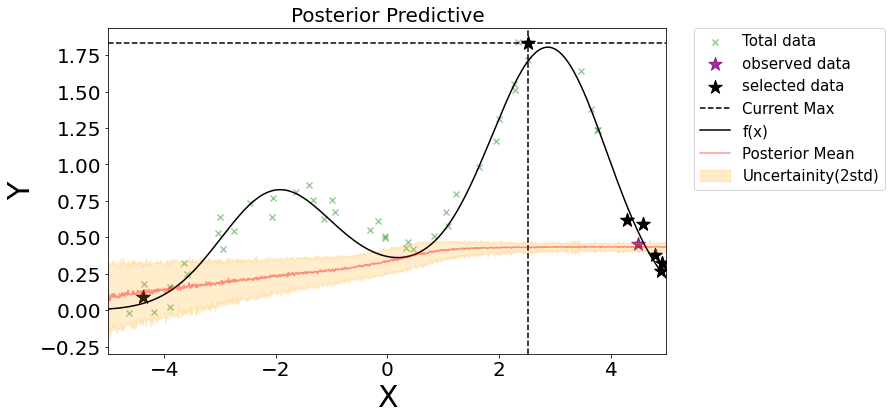

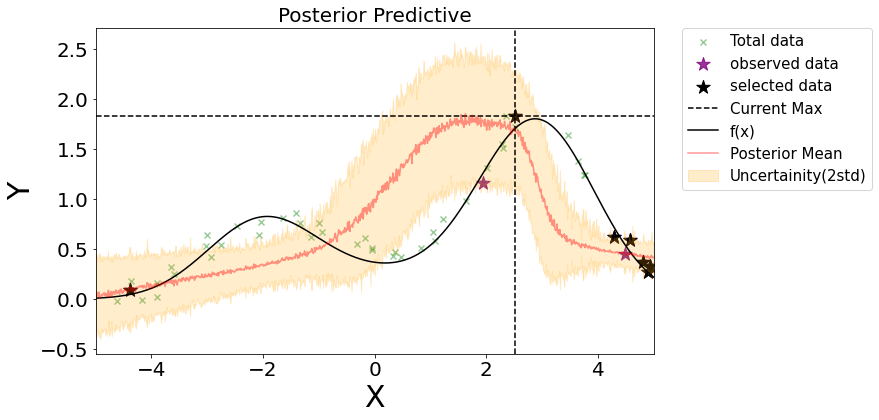

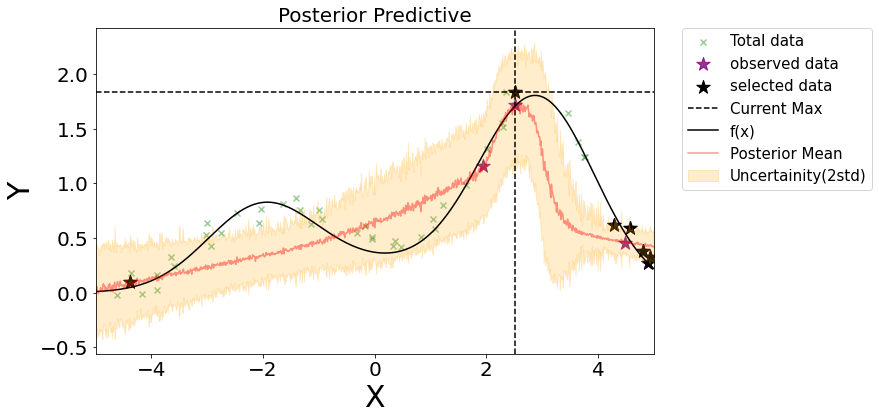

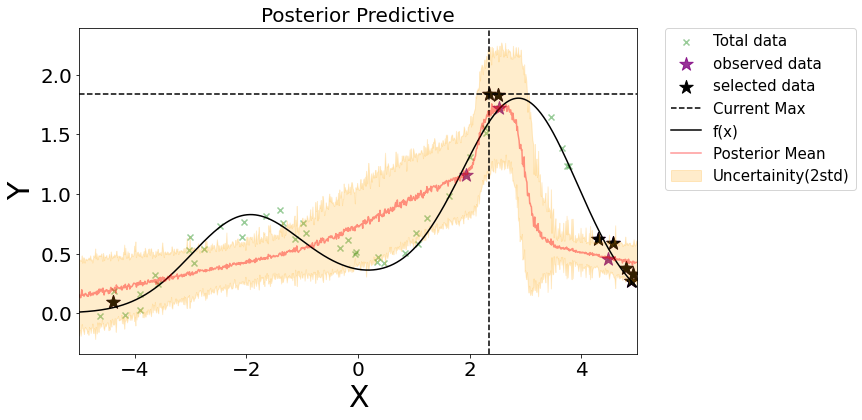

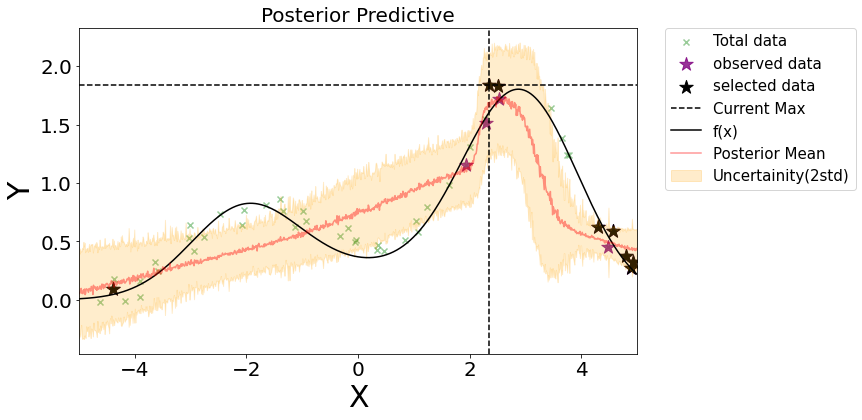

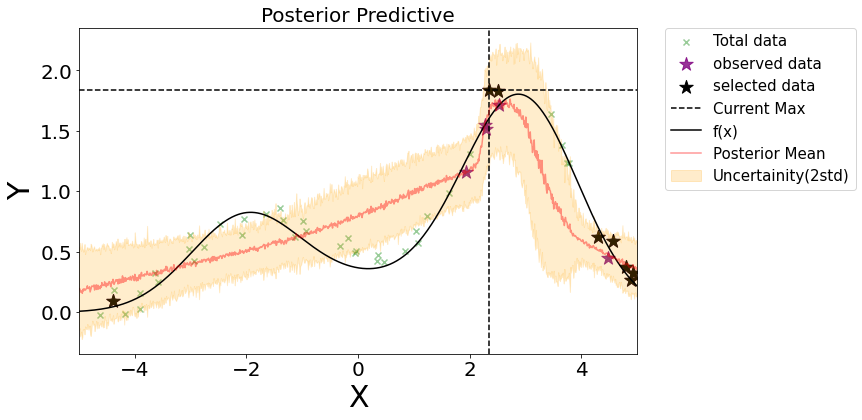

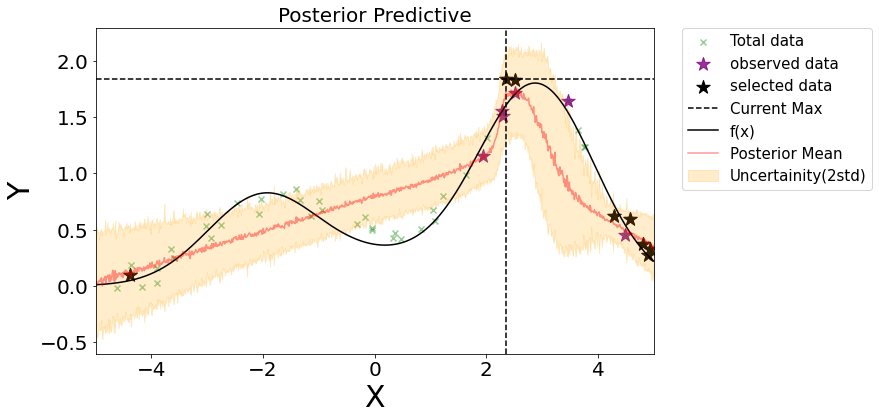

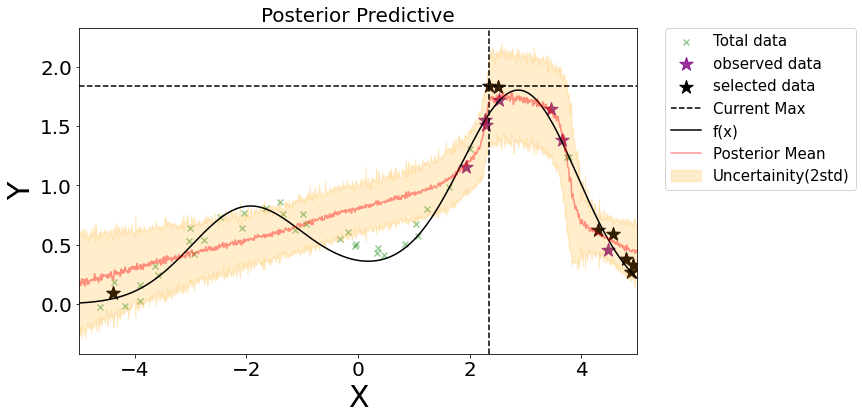

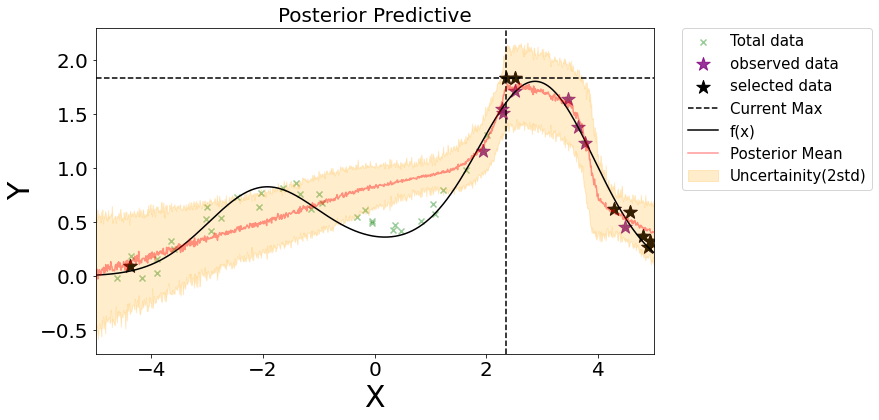

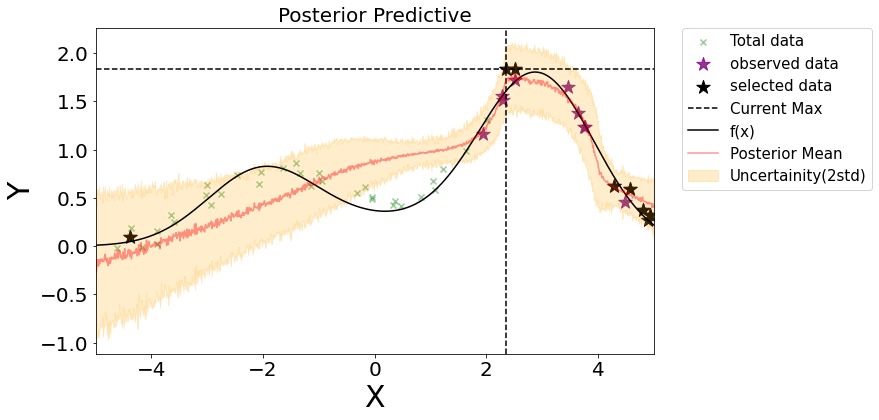

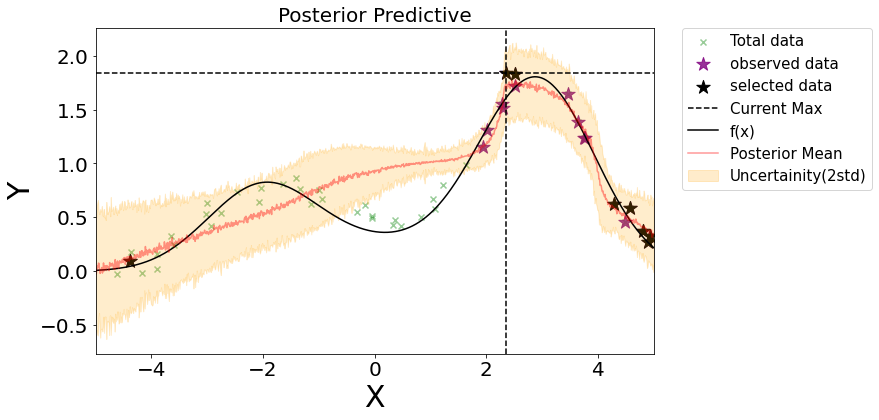

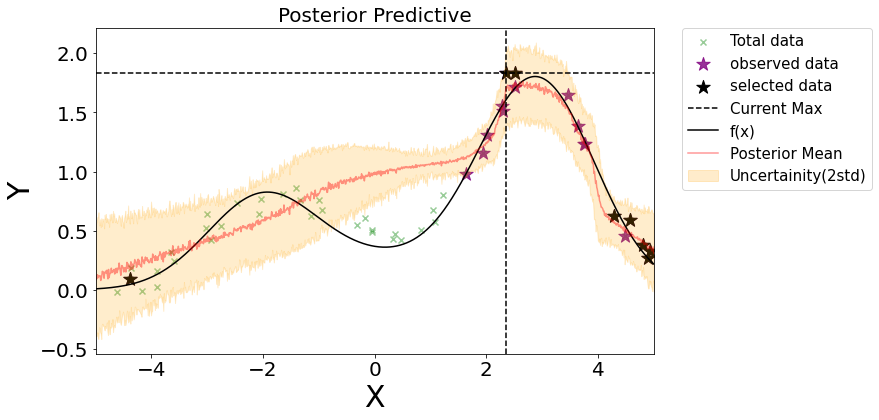

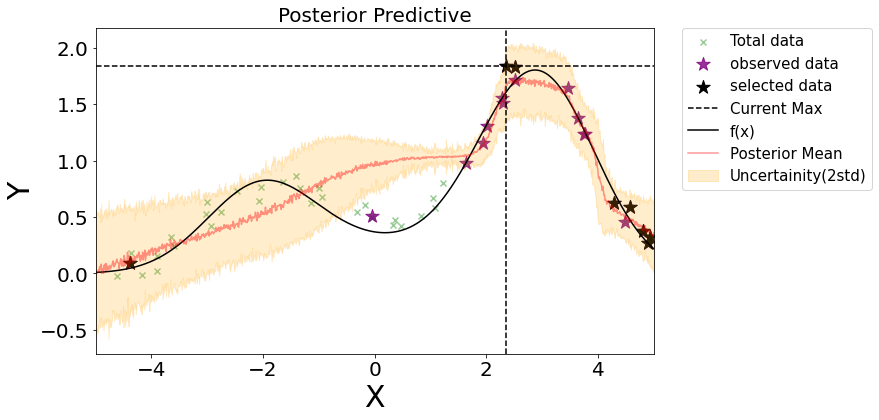

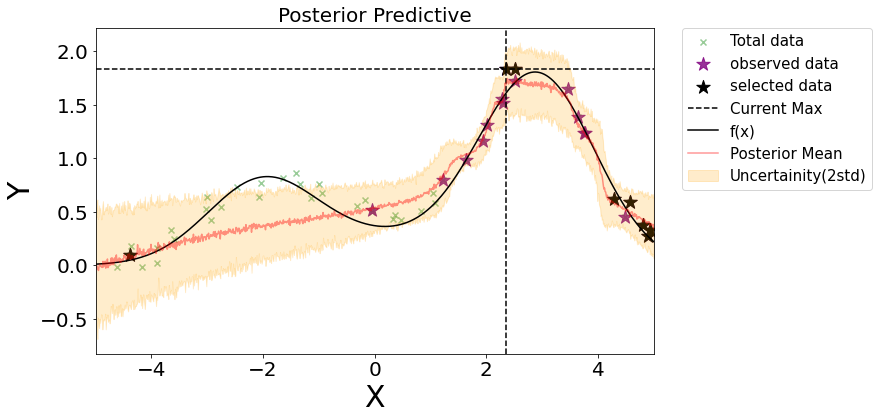

selected X:
tensor([[-4.3878],
        [ 4.9008],
        [ 4.9255],
        [ 4.8021],
        [ 4.5723],
        [ 4.2934],
        [ 2.5102],
        [ 2.3478]])
Final y:
tensor([[0.0931],
        [0.2703],
        [0.3264],
        [0.3758],
        [0.5898],
        [0.6219],
        [1.8317],
        [1.8364]])


In [420]:
acquisition_function = upper_confidence_bound # Choose acquisition function
num_iterations = 20
input_dim = 1
hidden_l1_dim = 100
hidden_l2_dim = 100
hidden_l3_dim = 100
output_dim = 1
model = MLP(input_dim, hidden_l1_dim, hidden_l2_dim,hidden_l3_dim,output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

ind = np.random.randint(50,size = 1)[0]
X_new = X_dataset[ind][:,None]
y_new = y_dataset[ind][:, None]
X_train, y_train,max_values_UCB = bayesian_optimization_loop(model, num_iterations,upper_confidence_bound,  X_new, y_new, X_dataset, y_dataset, optimizer)

print("selected X:")
print(X_train)
print("Final y:")
print(y_train)
# print("Max y:")
# print(max_values_UCB)

# Random search

In [274]:
def random_search_loop(model, num_iterations, X_new, y_new,X_dataset, y_dataset, optimizer, criterion, num_epochs=1000):
    X_data_full = X_dataset.clone()
    y_data_full = y_dataset.clone()
    X_train = X_new.clone()
    y_train = y_new.clone()
    X_obs = X_train.clone()
    y_obs = y_train.clone()
    max_values =[]
    for i in range(num_iterations):
        

        # Update the model with the new data point
        model = update(model, X_obs, y_obs, optimizer, criterion, num_epochs=num_epochs)
        
        # Perform MC dropout prediction
        mean_predictions, std_predictions = posterior_predictive(model, X_dataset, p=0.5)
        
        y_max = y_train.max()
        
        # Randomly select a point from the dataset
        idx = np.random.randint(len(X_dataset))
        next_x = X_dataset[idx]
        next_y = y_dataset[idx]

        if next_y > y_max:
        # Add new point to training data
            X_train = torch.cat((X_train, torch.tensor([[next_x]])))
            y_train = torch.cat((y_train, torch.tensor([[next_y]])))
        
        X_obs = torch.cat((X_obs, torch.tensor([[next_x]])))
        y_obs = torch.cat((y_obs, torch.tensor([[next_y]])))    
        
        # Remove selected point from dataset
        X_dataset = X_dataset[X_dataset!=X_dataset[idx]][:,None]
        y_dataset = y_dataset[y_dataset!=y_dataset[idx]][:,None]
        
        max_values.append(float(y_max))
        plot_posterior_predictive(X_data_full, y_data_full, X_obs.detach().numpy(), y_obs.detach().numpy(), X_train.detach().numpy(), y_train.detach().numpy(), model)

        
    return X_train, y_train, max_values

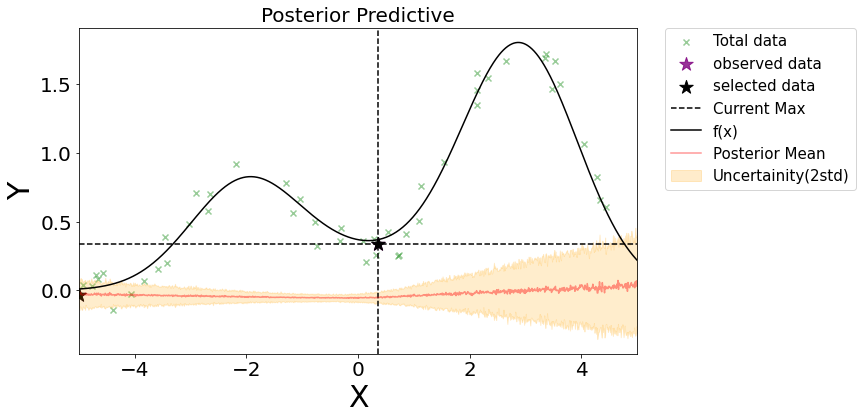

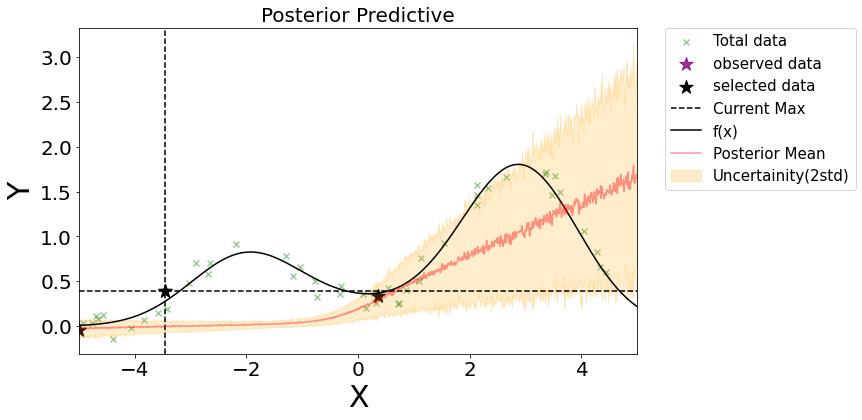

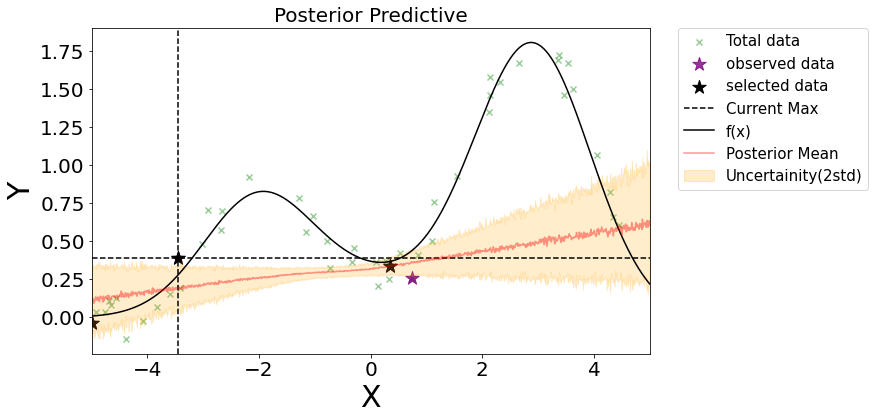

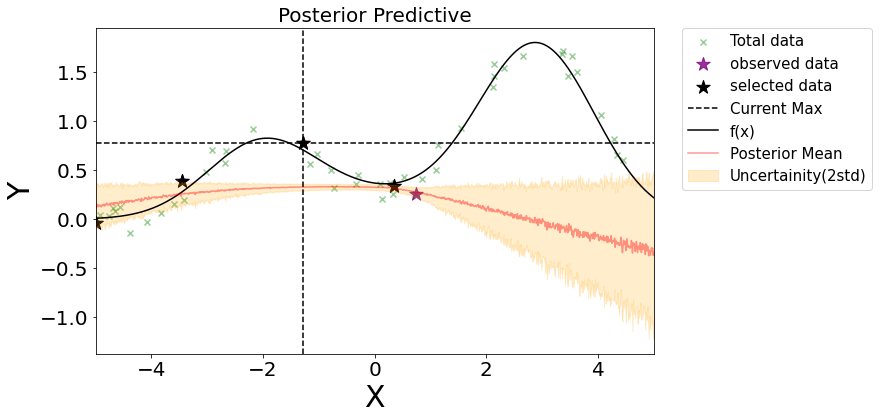

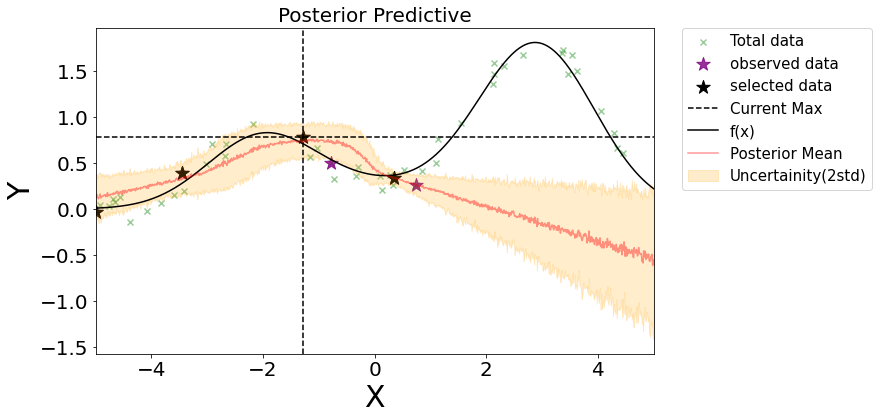

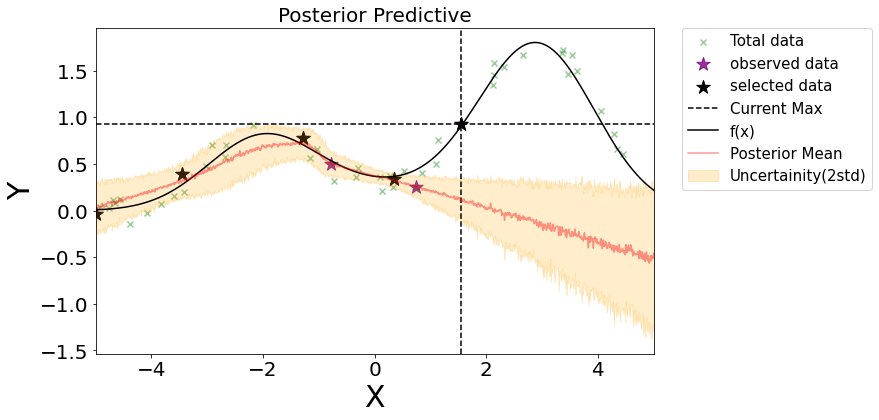

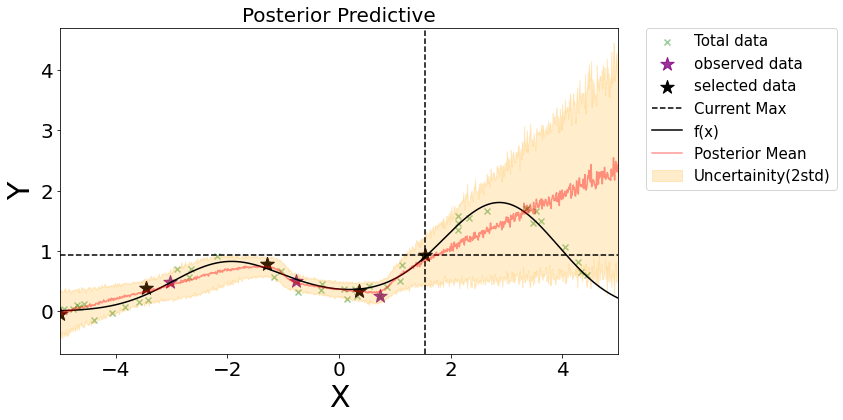

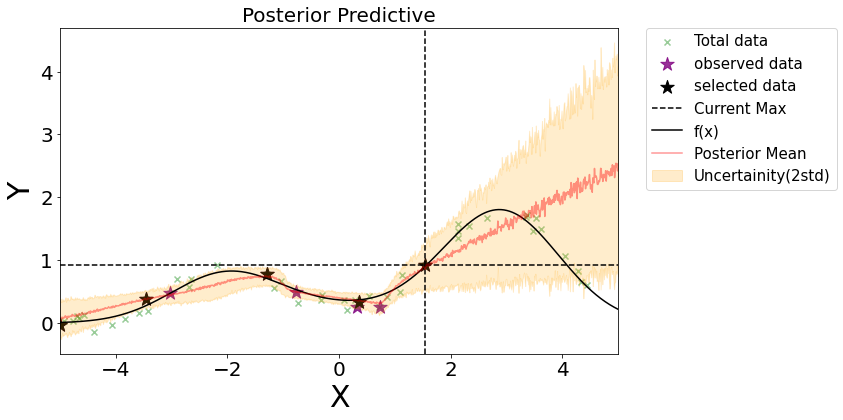

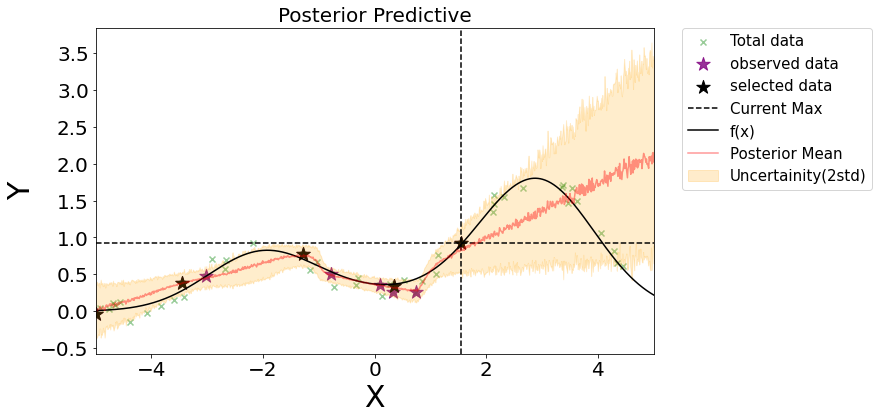

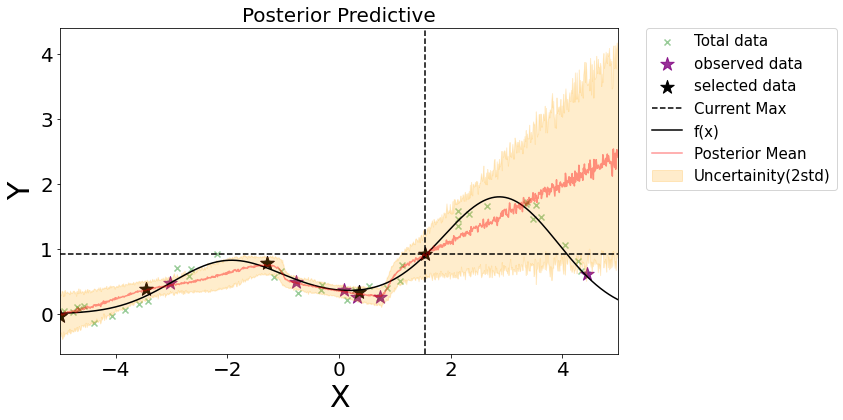

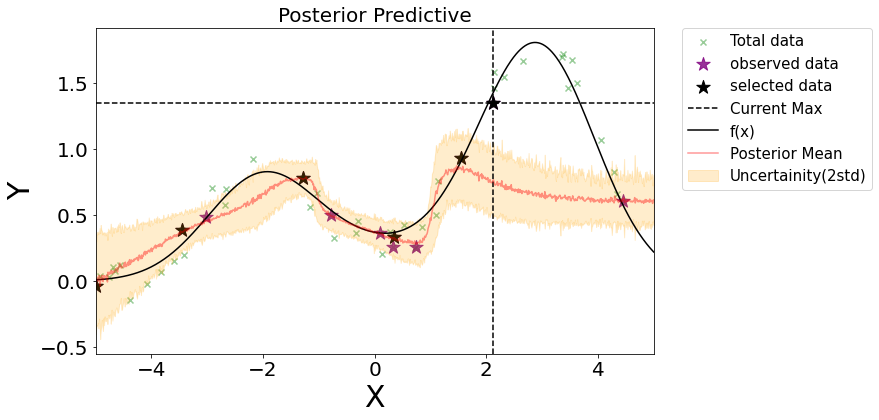

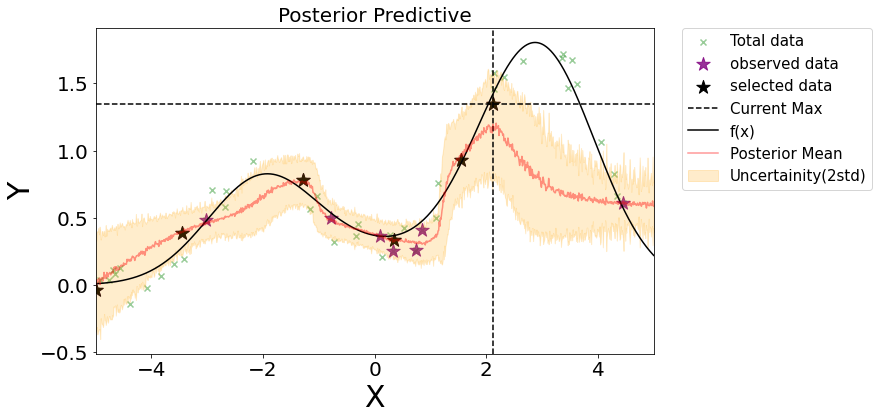

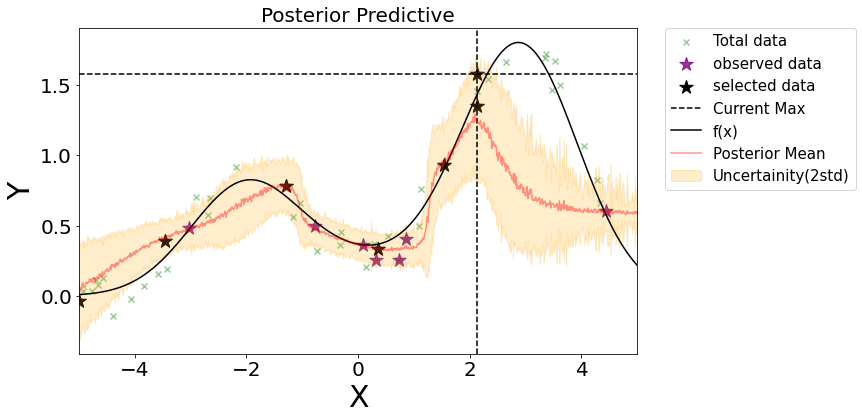

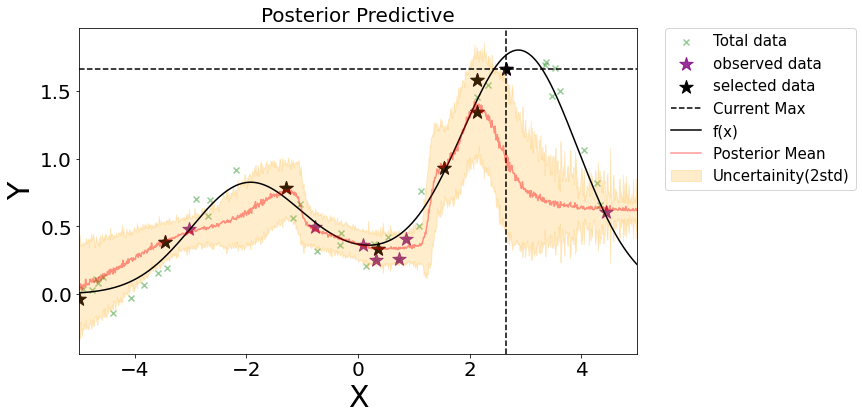

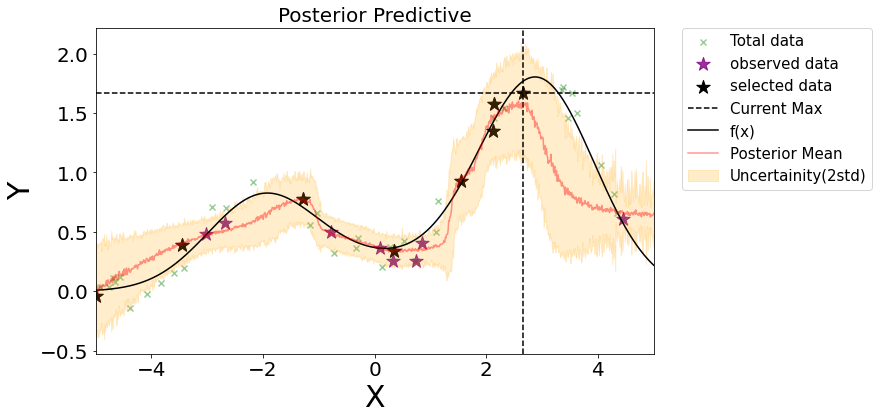

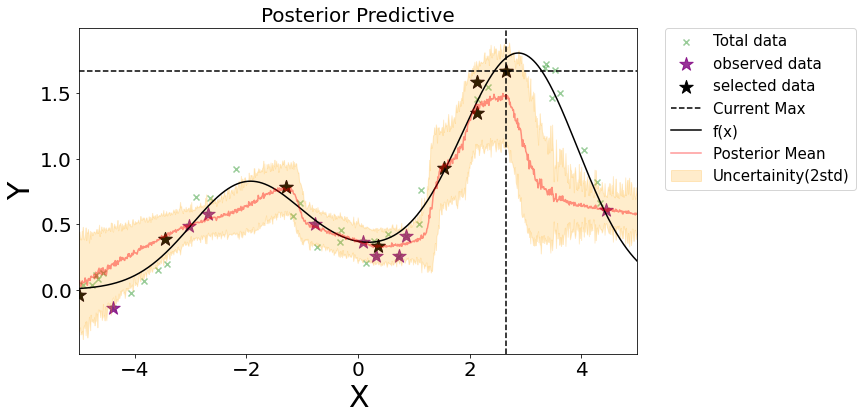

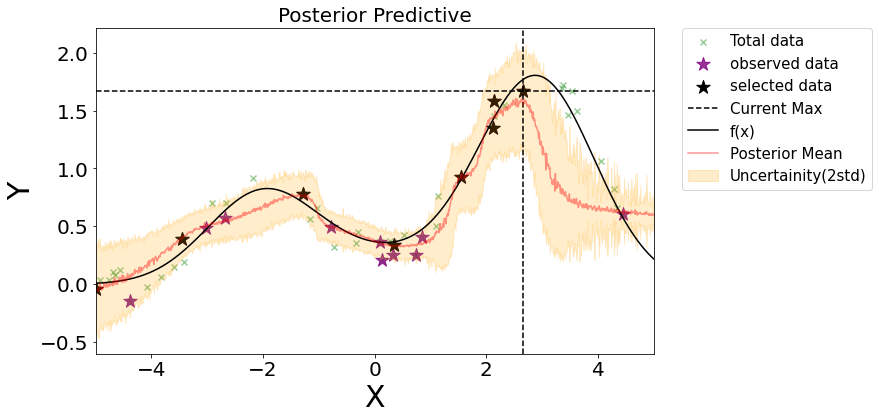

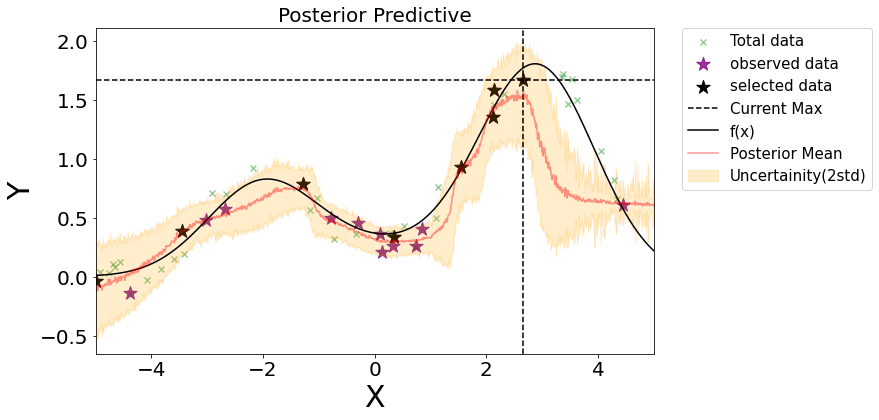

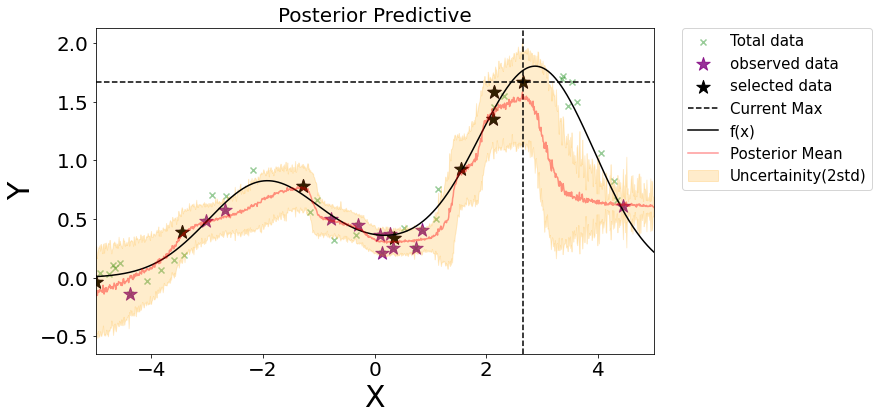

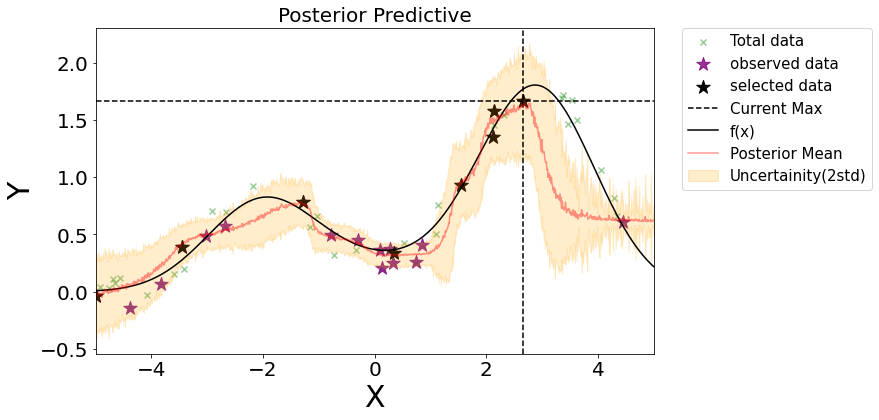

selected X:
tensor([[-4.9981],
        [ 0.3529],
        [-3.4584],
        [-1.2854],
        [ 1.5484],
        [ 2.1290],
        [ 2.1344],
        [ 2.6510]])
Final y:
tensor([[-0.0379],
        [ 0.3357],
        [ 0.3882],
        [ 0.7807],
        [ 0.9301],
        [ 1.3497],
        [ 1.5796],
        [ 1.6669]])


In [275]:
# Random search loop
num_iterations = 20
input_dim = 1
hidden_l1_dim = 100
hidden_l2_dim = 100
hidden_l3_dim = 100
output_dim = 1

model = MLP(input_dim, hidden_l1_dim, hidden_l2_dim,hidden_l3_dim,output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


ind = np.random.randint(50,size = 1)[0]
X_new = X_dataset[ind][:,None]
y_new = y_dataset[ind][:, None]
X_train, y_train, max_values_RS = random_search_loop(model, num_iterations,  X_new, y_new, X_dataset, y_dataset, optimizer,criterion)

print("selected X:")
print(X_train)
print("Final y:")
print(y_train)
# print("Max y_random search:")
# print(max_values_RS)

# Grid search

In [439]:
def f(x):
    means = [-2, 0, 3, 2]  # Mean values for the Gaussian components
    variances = [1, 1, 1, 1]  # Variance values for the Gaussian components
    amplitudes = [2, 0.5, 4, 0.8]  # Amplitude values for the Gaussian components
    variances = torch.tensor(variances)
    pdfs = []
    for mean, variance, amplitude in zip(means, variances, amplitudes):
        pdf = amplitude * torch.exp(-0.5 * ((x - mean) / variance)**2) / torch.sqrt(2 * np.pi * variance**2)
        pdfs.append(pdf)
    mixture_pdf = sum(pdfs)
    return mixture_pdf

def grid_search_loop(model, num_iterations, X_dataset, y_dataset, optimizer, criterion, num_epochs=100):
    X_data_full = X_dataset.clone()
    y_data_full = y_dataset.clone()
    X_train = X_dataset[0]
    y_train = y_dataset[0]
    X_obs = X_train.clone()
    y_obs = y_train.clone()
    
#     print(X_train.shape)
    model = update(model, X_train, y_train, optimizer, criterion, num_epochs=num_epochs)
    plot_posterior_predictive(X_data_full, y_data_full, X_obs.detach().numpy(), y_obs.detach().numpy(), X_train.detach().numpy(), y_train.detach().numpy(), model)
    max_values = []
    # Select a point from the dataset using grid search
    for idx in range(1, num_iterations):
        # Update the model with the new data point
        
        next_x = X_data_full[idx]
        next_y = y_data_full[idx]

        y_max = y_train.max()
        
        if next_y > y_max:
            # Add new point to training data
            X_train = torch.cat((X_train, next_x))
            y_train = torch.cat((y_train, next_y))
            print(X_train.shape)
            print(next_x.shape)
            model = update(model, X_train[:,None], y_train[:,None], optimizer, criterion, num_epochs=num_epochs)

        X_obs = torch.cat((X_obs, next_x))
        y_obs = torch.cat((y_obs, next_y))    


        max_values.append(float(y_max))
        plot_posterior_predictive(X_data_full, y_data_full, X_obs.detach().numpy(), y_obs.detach().numpy(), X_train.detach().numpy(), y_train.detach().numpy(), model)


    return X_train, y_train, max_values

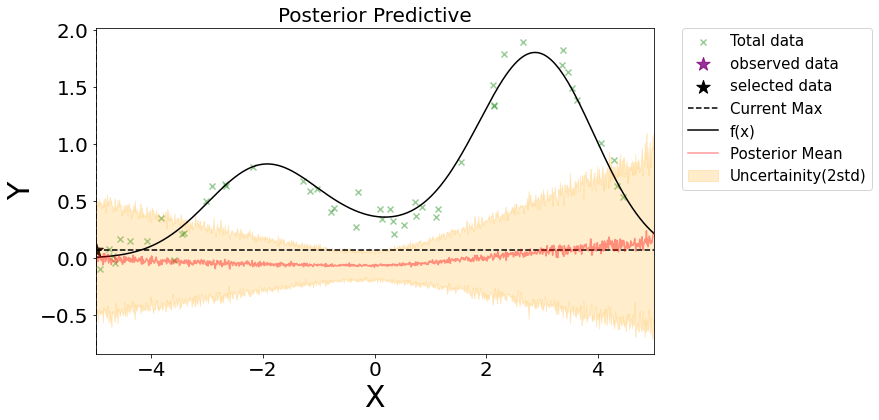

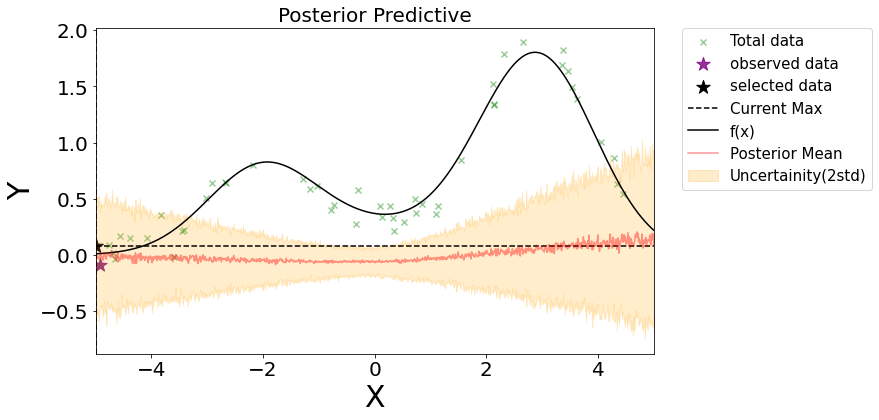

torch.Size([2])
torch.Size([1])


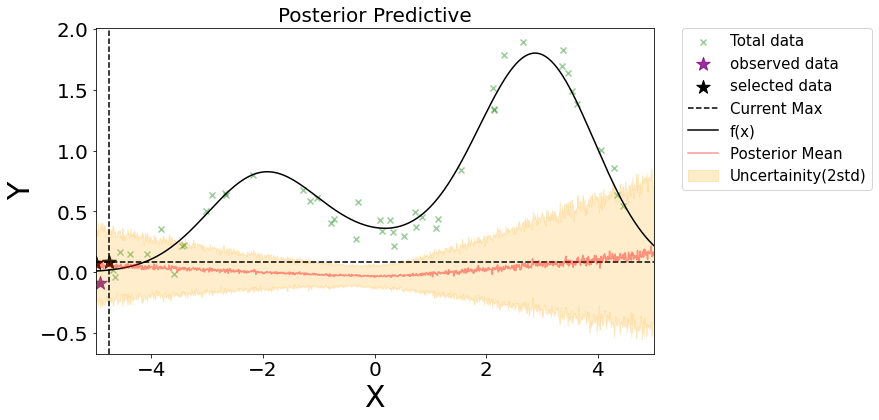

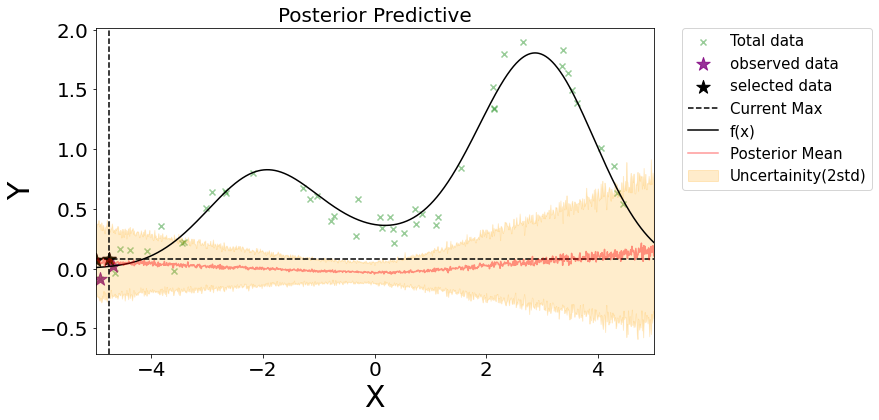

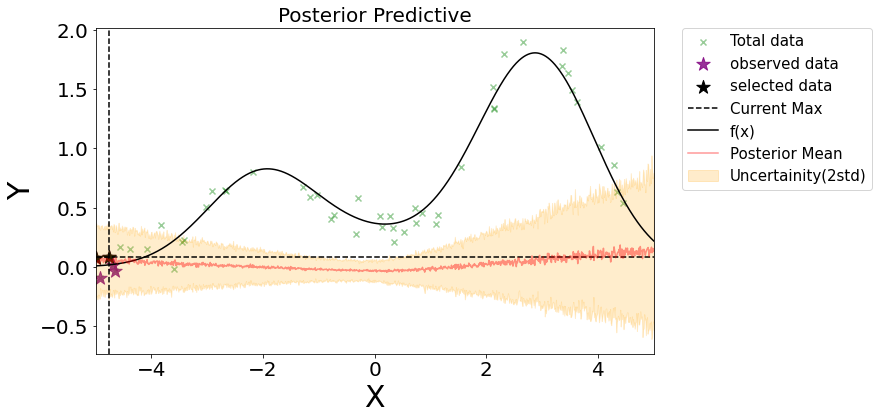

torch.Size([3])
torch.Size([1])


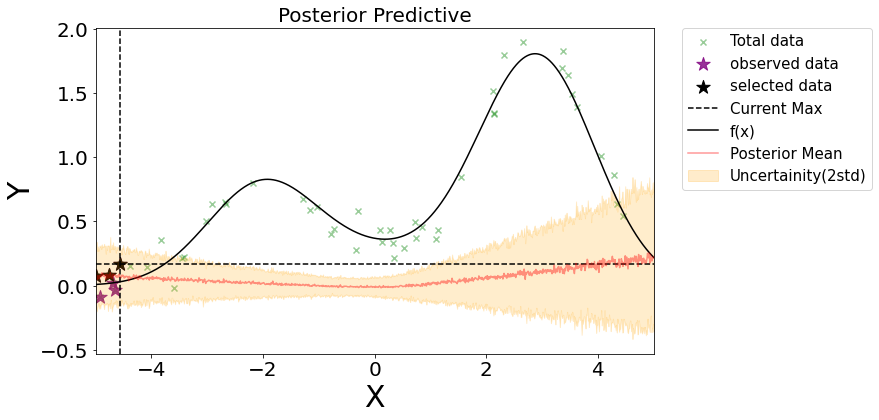

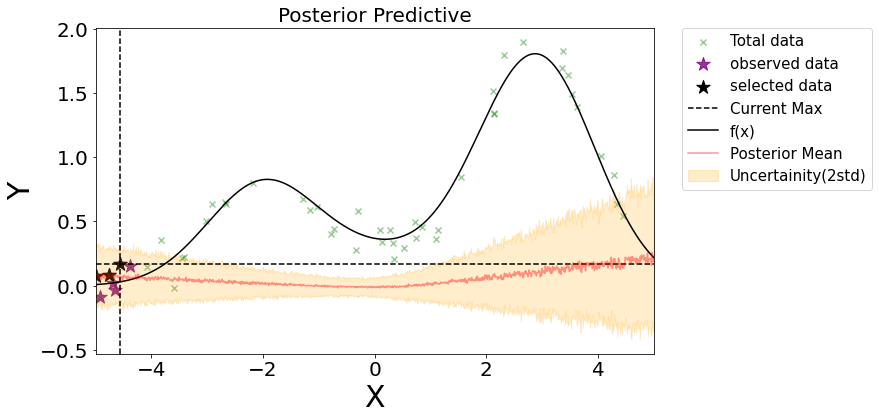

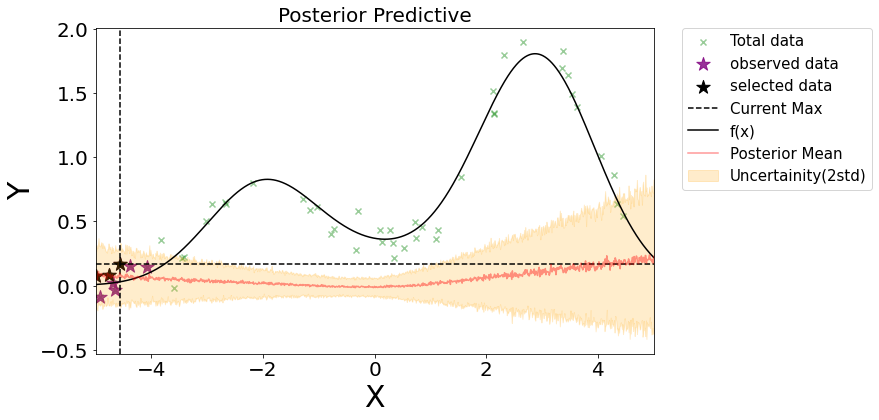

torch.Size([4])
torch.Size([1])


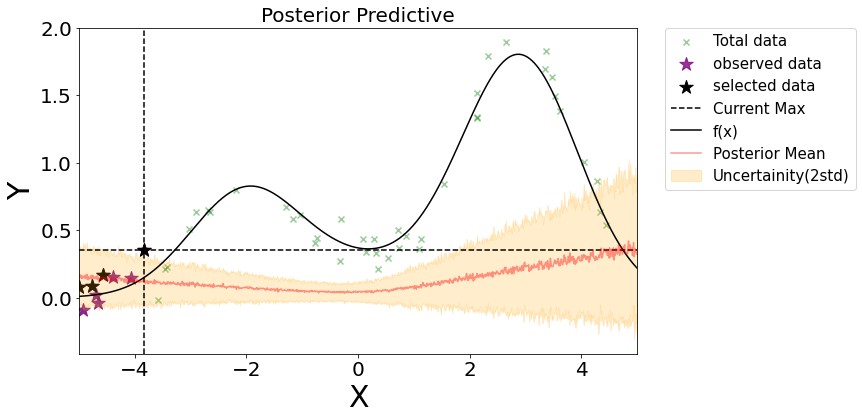

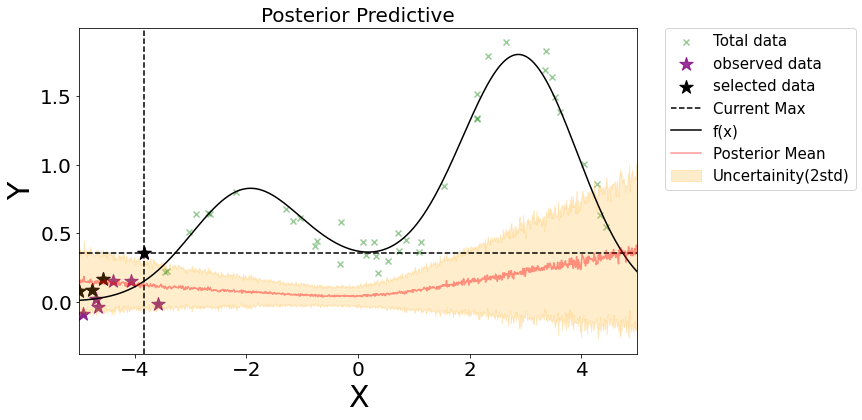

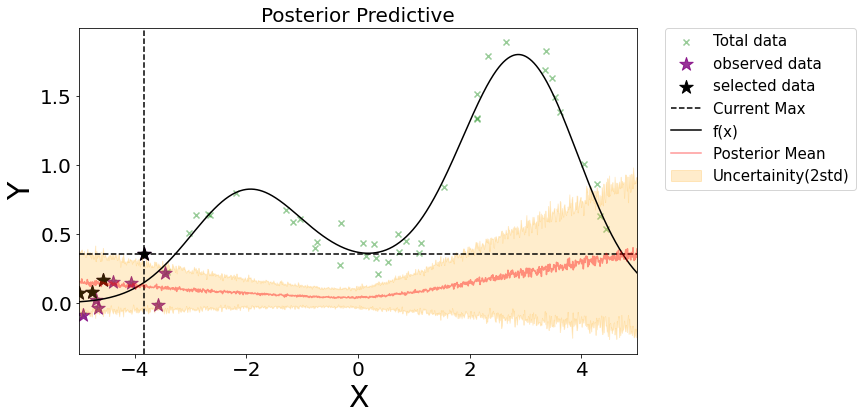

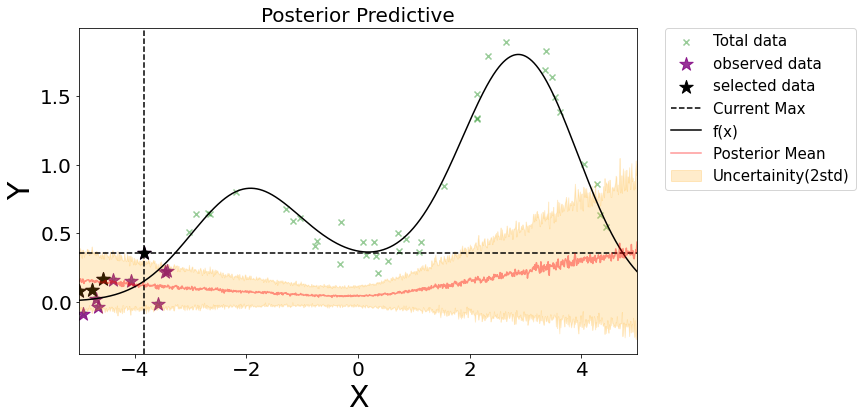

torch.Size([5])
torch.Size([1])


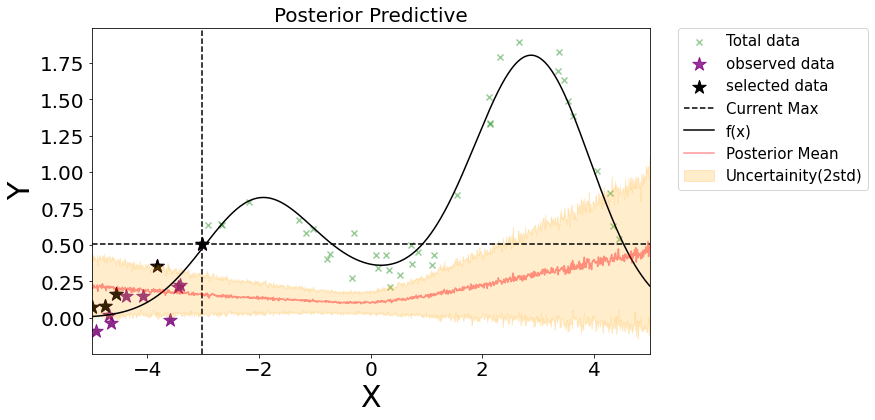

torch.Size([6])
torch.Size([1])


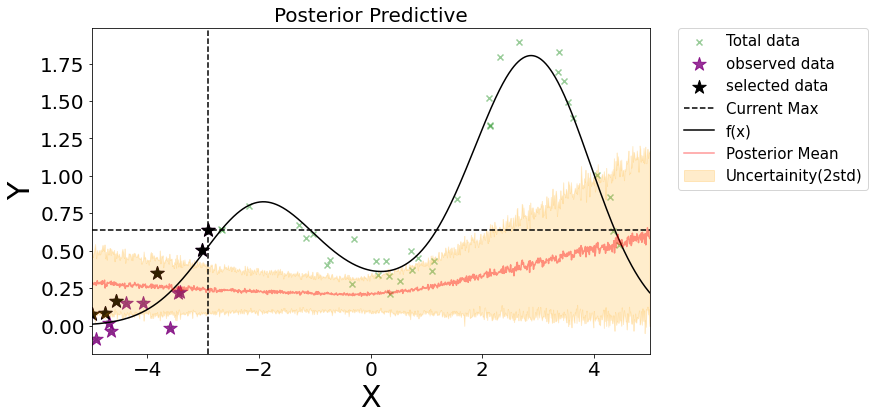

torch.Size([7])
torch.Size([1])


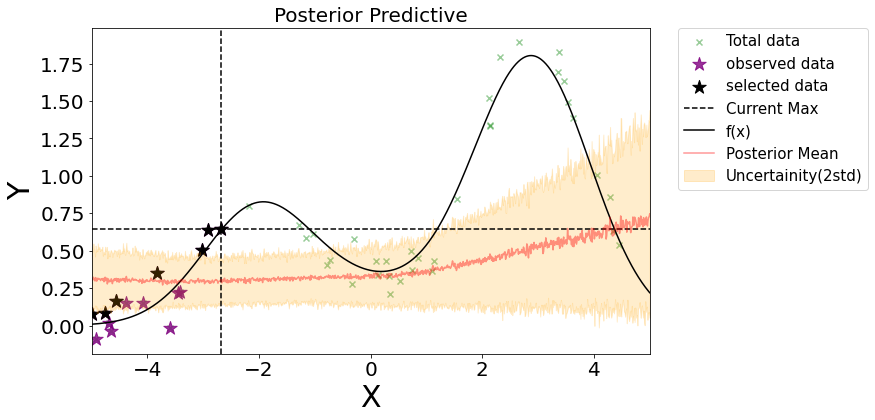

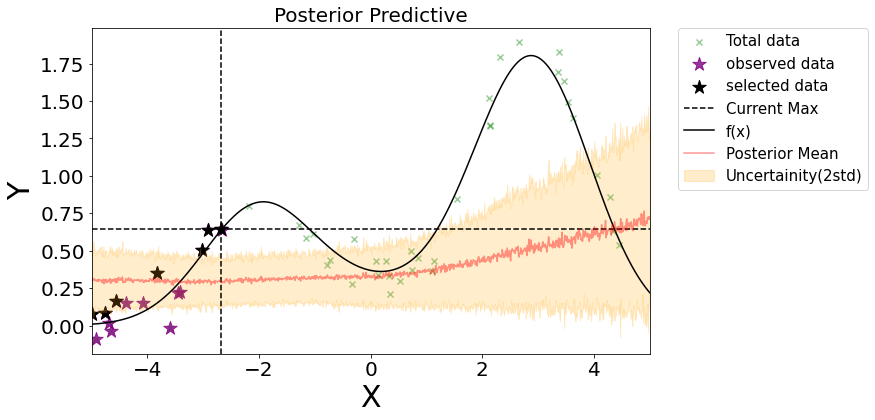

torch.Size([8])
torch.Size([1])


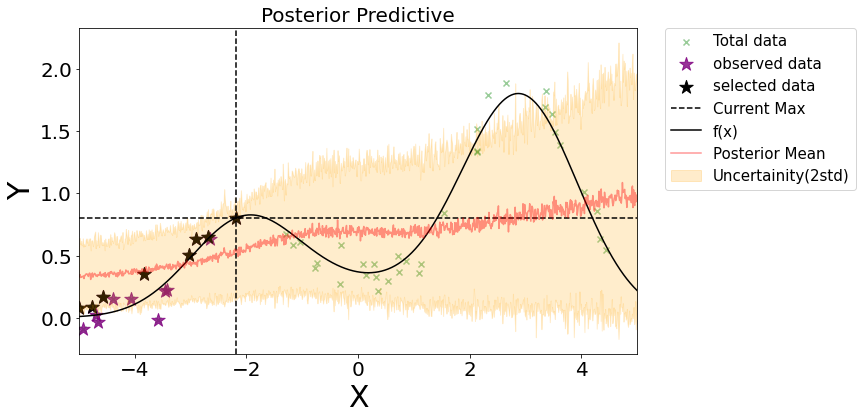

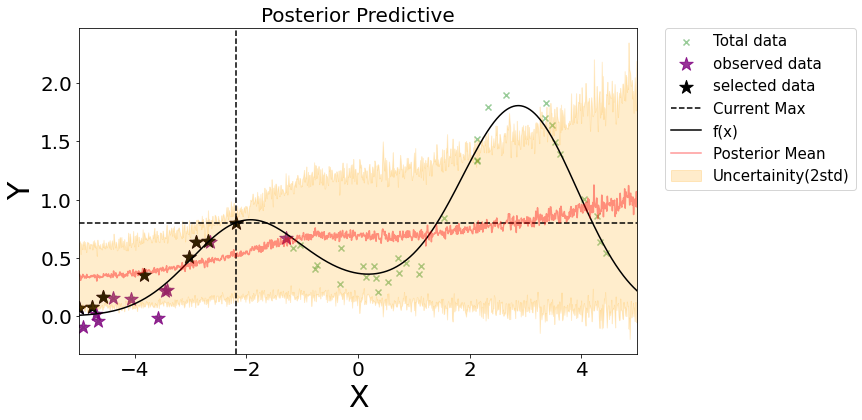

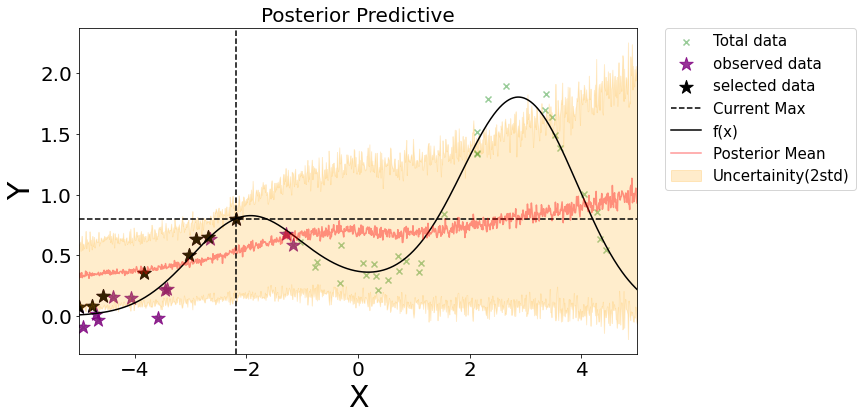

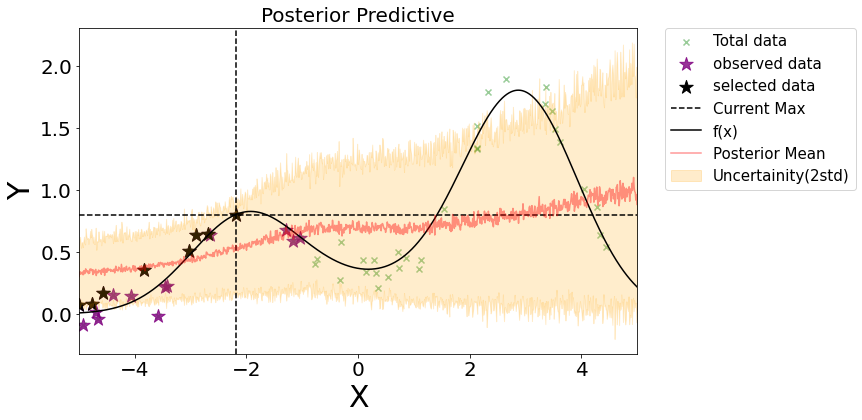

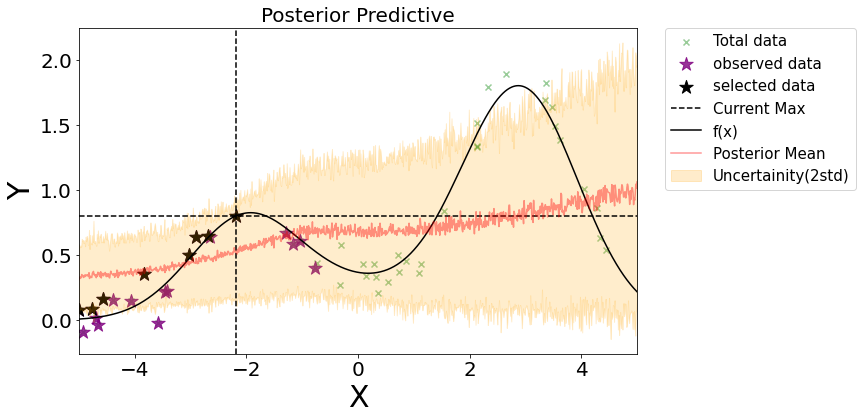

selected X:
tensor([-4.9981, -4.7626, -4.5688, -3.8386, -3.0225, -2.9077, -2.6878, -2.1807])
Final y:
tensor([0.0751, 0.0833, 0.1657, 0.3530, 0.5054, 0.6368, 0.6481, 0.7983])



In [401]:
# Grid search loop
num_iterations = 21
input_dim = 1
hidden_l1_dim = 100
hidden_l2_dim = 100
hidden_l3_dim = 100
output_dim = 1

model = MLP(input_dim, hidden_l1_dim, hidden_l2_dim,hidden_l3_dim,output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

X_data_grid = list(X_dataset.sort(0))[0]
f_data_grid = f(X_data_grid)
y_data_grid = f_data_grid + torch.distributions.Normal(0, 0.1).sample((50, 1))
    

X_train, y_train, max_values_GS = grid_search_loop(model, num_iterations, X_data_grid, y_data_grid, optimizer,criterion)

print("selected X:")
print(X_train)
print("Final y:")
print(y_train)
print()

# Comparison of different search techniques

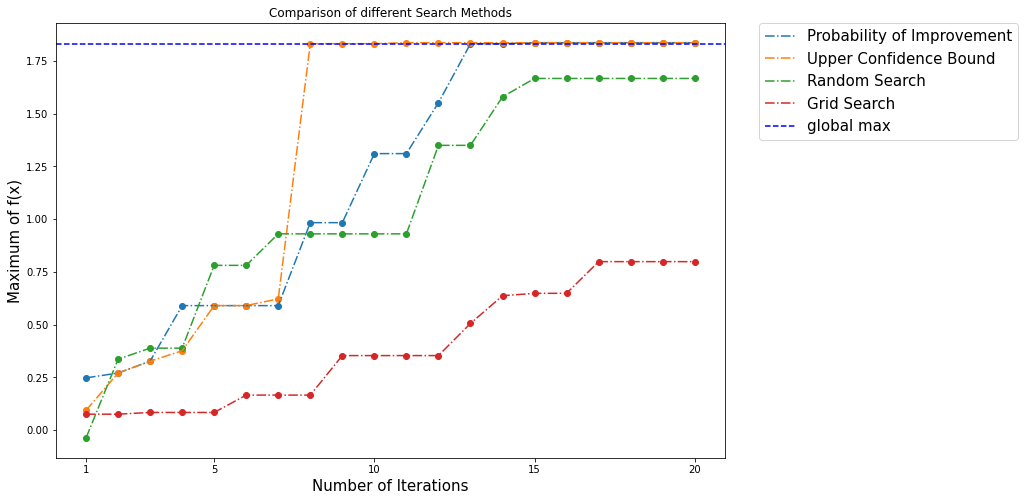

In [435]:
def plot_comparison(max_values_prob_improve, max_values_ucb,max_values_RS):
    iterations = list(range(1, len(max_values_PI) + 1))
    plt.figure(figsize=(12, 8))
    plt.plot(iterations, max_values_PI, label='Probability of Improvement',ls='dashdot')
    plt.scatter(iterations,max_values_PI)
    plt.plot(iterations, max_values_UCB, label='Upper Confidence Bound',ls='dashdot')
    plt.scatter(iterations,max_values_UCB)
    plt.plot(iterations, max_values_RS, label='Random Search',ls='dashdot')
    plt.scatter(iterations,max_values_RS)
    plt.plot(iterations, max_values_GS, label='Grid Search',ls='dashdot')
    plt.scatter(iterations,max_values_GS)

    plt.axhline(y=1.83, color='b',label='global max', linestyle='--')
    plt.xticks([1,5,10,15,20])
    plt.xlabel('Number of Iterations',fontsize=15)
    plt.ylabel('Maximum of f(x)',fontsize=15)
    plt.title('Comparison of different Search Methods')
#     plt.legend()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=15, borderaxespad=0.)
    plt.show()

# Plot the comparison
plot_comparison(max_values_PI, max_values_UCB,max_values_RS )
